# Hospital readmission classification project

In [202]:
# Let's load in our libraries:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score 





In [2]:
# Let's configure jupyter for rendering plots! 
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


In [3]:
diabetic_data = pd.read_csv('diabetic_data.csv')

In [4]:
diabetic_data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

## 1 - EDA

In [781]:
# diabetic_data.info()

In [780]:
# diabetic_data.describe()

Class imbalance:

diabetic_data.readmitted.value_counts()

In [7]:
11357/(54864+35545+11357)*100

11.159915885462727

Seems like null values are reported with the symbol '?'. Let's convert the '?' into NaN values:

In [8]:
diabetic_data.replace('?', np.NaN,inplace=True)

In [9]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Create the target column: readmitted_binary_target

In [10]:
def makes_target_binary(row):
    if row == '<30':
        return 1
    else:
        return 0
    
diabetic_data['readmitted_binary_target'] =  diabetic_data['readmitted'].apply(makes_target_binary)   

In [11]:
diabetic_data['readmitted_binary_target'].value_counts()

0    90409
1    11357
Name: readmitted_binary_target, dtype: int64

In [13]:
diabetic_data['encounter_id'].nunique() # All encounters are unique. No duplicates.

101766

Check the target distribution, to determine if this is an imbalanced classification task:

0    0.888401
1    0.111599
Name: readmitted_binary_target, dtype: float64


<AxesSubplot:>

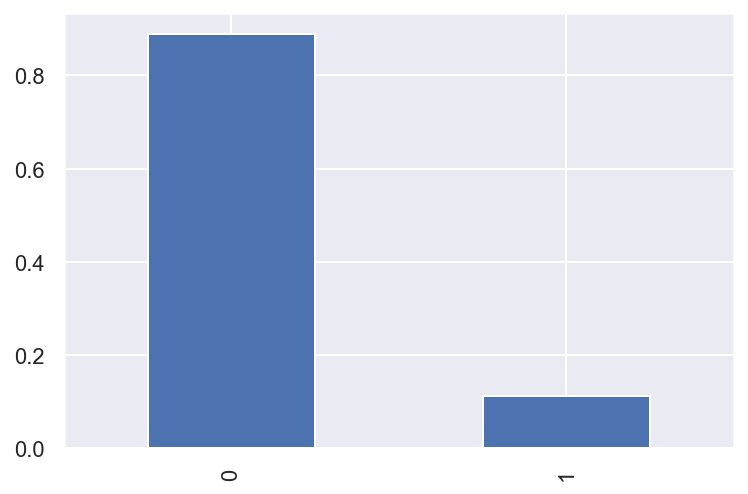

In [14]:
target_values = diabetic_data.readmitted_binary_target.value_counts(normalize=True) 
print(target_values)

target_values.plot(kind='bar')

So, we have an imbalanced classification task.

In [15]:
# Unique values for 
diabetic_data['patient_nbr'].nunique()

71518

In [16]:
diabetic_data['patient_nbr'].value_counts()

88785891     40
43140906     28
1660293      23
88227540     23
23199021     23
             ..
11005362      1
98252496      1
1019673       1
13396320      1
175429310     1
Name: patient_nbr, Length: 71518, dtype: int64

In [783]:
# diabetic_data[diabetic_data['patient_nbr'] == 88785891]

In [19]:
data_model_1 = diabetic_data[['patient_nbr','num_procedures','num_medications','number_diagnoses','readmitted_binary_target']].copy()

train/test/validation split

In [476]:
features_model_1 = ['patient_nbr','num_procedures','num_medications','number_diagnoses','readmitted_binary_target']
df_model_1 = diabetic_data[features_model_1].copy()

df_model_1.columns = features_model_1
df_model_1.head()

patient_nbr  num_procedures  num_medications  number_diagnoses  \
0      8222157               0                1                 1   
1     55629189               0               18                 9   
2     86047875               5               13                 6   
3     82442376               1               16                 7   
4     42519267               0                8                 5   

   readmitted_binary_target  
0                         0  
1                         0  
2                         0  
3                         0  
4                         0

In [63]:
def prepares_dataset_modeling(features_model,diabetic_data):
    final_features = ['patient_nbr','readmitted_binary_target']
    final_features.extend(features_model)
    df_model = diabetic_data[final_features].copy()
    df_model.columns = final_features
    return df_model



With this splitting function in hand, we're ready to train and evaluate our simple baseline model.

In [617]:
def get_patient_split_data_first_split(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_patients = df['patient_nbr'].unique() 
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)

    Xy = df[~df['patient_nbr'].isin(test_patients)]
    df_te = df[df['patient_nbr'].isin(test_patients)] 

    y_te = df_te['readmitted_binary_target']
    
    X_te = df_te.drop(['readmitted_binary_target'],axis=1)

    return Xy, X_te, y_te

In [171]:
(Xy.readmitted_binary_target == 1).sum()

9188

In [618]:
Xy, X_test, y_test = get_patient_split_data_first_split(df_model_1)

In [185]:
def get_patient_split_data_second_split(df, test_size=.25, seed=40):

    rs = np.random.RandomState(seed)
    
    total_patients = df['patient_nbr'].unique() 
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['patient_nbr'].isin(test_patients)]
    df_te = df[df['patient_nbr'].isin(test_patients)] 

    y_tr, y_te = df_tr['readmitted_binary_target'], df_te['readmitted_binary_target']
    
    X_tr = df_tr.drop(['readmitted_binary_target'],axis=1) 
    X_te = df_te.drop(['readmitted_binary_target'],axis=1)

    return X_train, X_val, y_train, y_val,df_tr

In [186]:
X_train, X_val, y_train, y_val,df_tr = get_patient_split_data_second_split(Xy)

In [510]:
len(X_train)+len(X_val) + len(X_test)

101766

0         0
1         0
2         0
7         0
8         0
         ..
101757    0
101760    0
101761    0
101762    0
101763    0
Name: readmitted_binary_target, Length: 61074, dtype: int64

In [78]:
def plot_features(df, sample_size=500):
    sample = (df.drop(['patient_nbr'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='readmitted_binary_target', plot_kws=dict(alpha=.3, edgecolor='none'))



### Simple model 1

In [187]:
# Specificy features (other than target and the patient ID):
features_model_1 = ['num_procedures','num_medications','number_diagnoses']
# Generate new dataframe for modeling:
df_model_1 = prepares_dataset_modeling(features_model_1,diabetic_data)
# 80/20 training/holdout split. 
Xy, X_test, y_test = get_patient_split_data_first_split(df_model_1)
# 75/25 train/test split (of the previous 80 split).
X_train, X_val, y_train, y_val,df_tr = get_patient_split_data_second_split(Xy)
del features_model_1 # 
# del df_model_1


In [189]:
Xy.head(100)

patient_nbr  readmitted_binary_target  num_procedures  num_medications  \
0        8222157                         0               0                1   
1       55629189                         0               0               18   
2       86047875                         0               5               13   
3       82442376                         0               1               16   
5       82637451                         0               6               16   
..           ...                       ...             ...              ...   
110     72405540                         0               5               22   
113     49407813                         0               2               13   
114      6915888                         1               1               19   
115     10430154                         0               0               11   
117       720936                         0               2               24   

     number_diagnoses  
0                   1  
1                   9  
2                   6  
3                   7  
5                   9  
..                ...  
110                 9  
113                 7  
114                 8  
115                 5  
117                 9  

[100 rows x 5 columns]

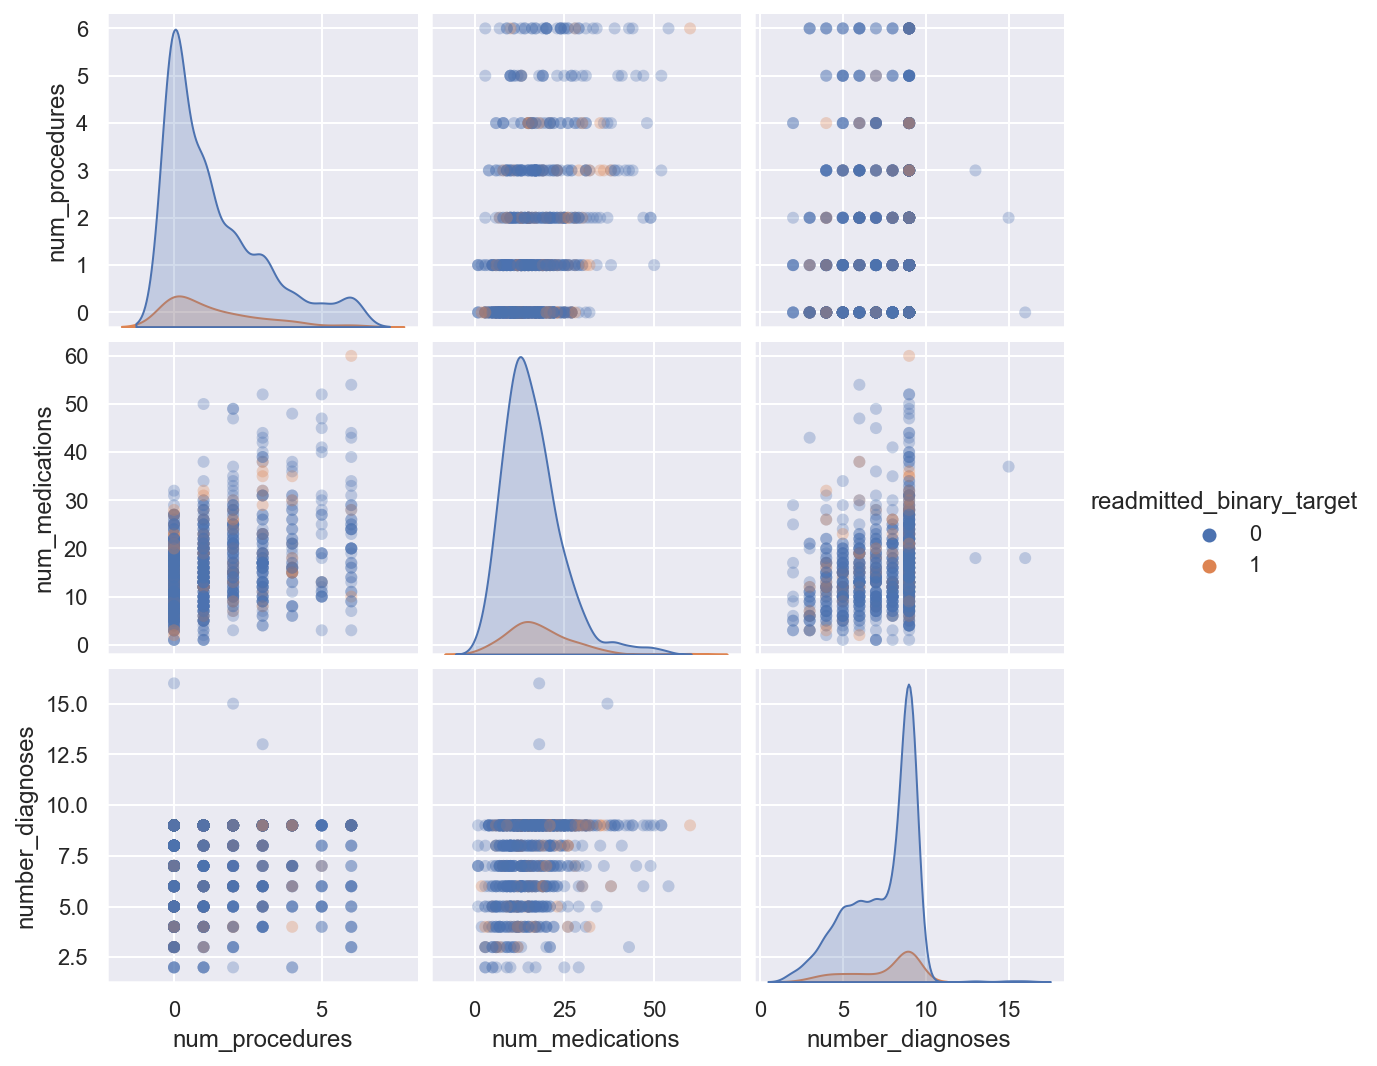

In [139]:
plot_features(df_tr)

In [140]:
lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)
print(lr.score(X_test, y_test)) # Because we are working with imbalanced data.

0.8930895110410094


In [141]:
lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)
f1_score(lr.predict(X_test), y_test)

0.0

In [142]:
lr.coef_

array([[-2.93177153e-08, -4.12671328e-15, -4.29115169e-14,
        -1.90087668e-14]])

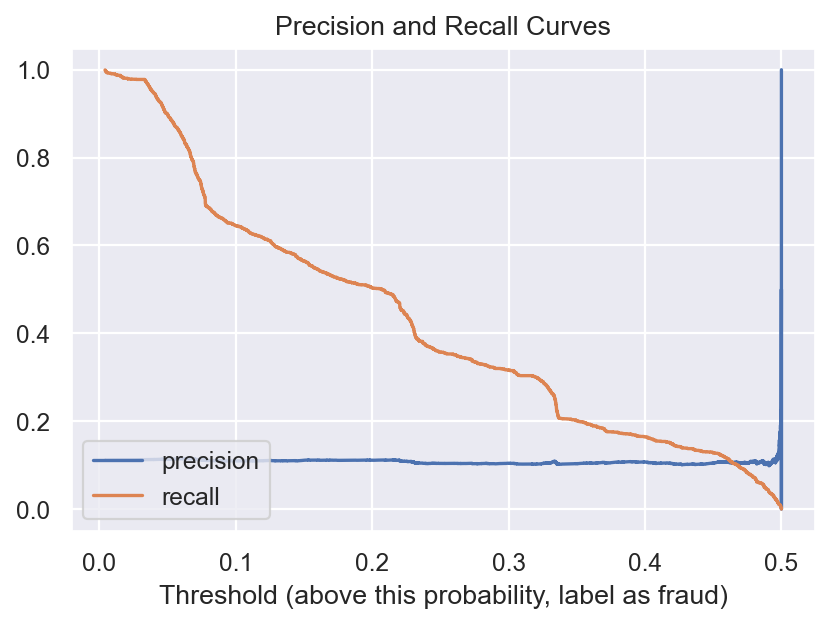

In [143]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, lr.predict_proba(X_val)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC curve

In [190]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lr.predict_proba(X_val)[:,1])

/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:484: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- num_lab_procedures
- number_emergency
- number_inpatient
- number_outpatient
- time_in_hospital
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


ValueError: X has 9 features, but LogisticRegression is expecting 4 features as input.

ROC AUC score =  0.4973923962621556


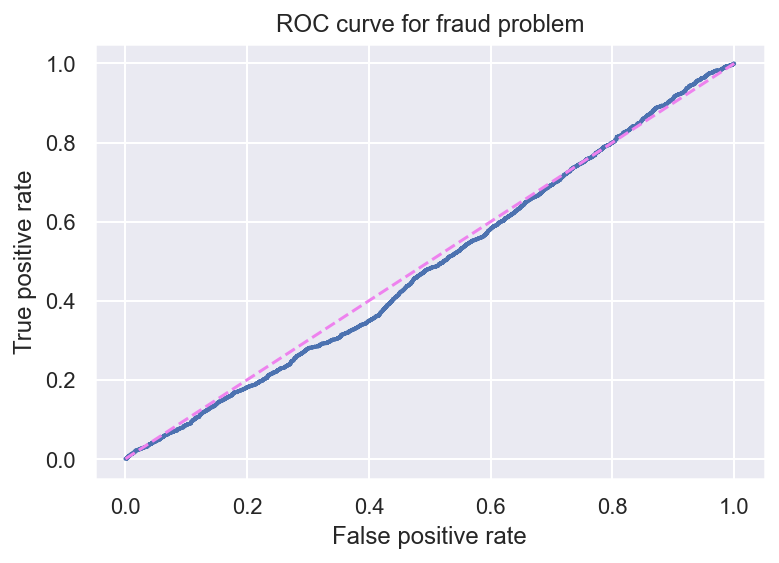

In [145]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_val, lr.predict_proba(X_val)[:,1]))

In [146]:
lr.predict_proba(X_val[:5,]) # It generates the predicted probabilities from each class (one per column below):



TypeError: '(slice(None, 5, None),)' is an invalid key

patient_nbr  time_in_hospital  num_lab_procedures  num_procedures  \
3          82442376                 2                  44               1   
5          82637451                 3                  31               6   
11         77391171                 7                  62               0   
12         85504905                 7                  60               0   
14         49726791                 1                  49               5   
...             ...               ...                 ...             ...   
101752    139605341                 3                  13               1   
101753    184875899                13                  51               2   
101754    183087545                 9                  50               2   
101758    120975314                 5                  76               1   
101765    175429310                 6                  13               3   

        num_medications  number_outpatient  number_emergency  \
3                    16                  0                 0   
5                    16                  0                 0   
11                   11                  0                 0   
12                   15                  0                 1   
14                    2                  0                 0   
...                 ...                ...               ...   
101752                5                  0                 0   
101753               13                  0                 0   
101754               33                  0                 0   
101758               22                  0                 1   
101765                3                  0                 0   

        number_inpatient  number_diagnoses  
3                      0                 7  
5                      0                 9  
11                     0                 7  
12                     0                 8  
14                     0                 8  
...                  ...               ...  
101752                 0                 8  
101753                 0                 9  
101754                 0                 9  
101758                 0                 9  
101765                 0                 9  

[20404 rows x 9 columns]

In [85]:
from sklearn.metrics import confusion_matrix





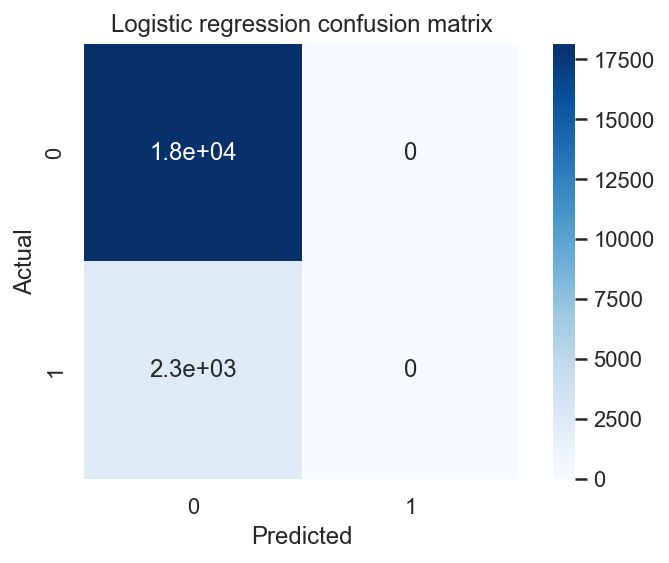

In [147]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, lr.predict(X_val))
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');



In [214]:
lr = LogisticRegression() # , solver='liblinear'
lr_balanced = LogisticRegression(class_weight='balanced')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1})

lr.fit(X_train, y_train)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, lr.predict(X_val)), roc_auc_score(y_val, lr.predict_proba(X_val)[:,1])))

Normal Logistic Regression Test F1: 0.000, Test AUC: 0.497


In [215]:
lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, lr_balanced.predict(X_val)), roc_auc_score(y_val, lr_balanced.predict_proba(X_val)[:,1])))

lr_4x.fit(X_train, y_train)
print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, lr_4x.predict(X_val)), roc_auc_score(y_val, lr_4x.predict_proba(X_val)[:,1])))

Balanced class weights Logistic Regression Test F1: 0.200, Test AUC: 0.503
4:1 class weights Logistic Regression Test F1: 0.000, Test AUC: 0.497


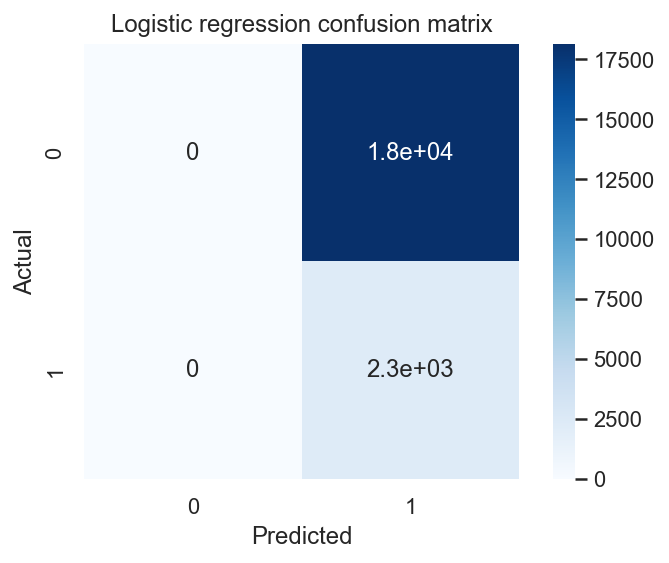

In [111]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, lr_balanced.predict(X_val))
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');



In [ ]:
from sklearn.model_selection import train_test_split

def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=10):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [208]:
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train)

0.8851279812257818

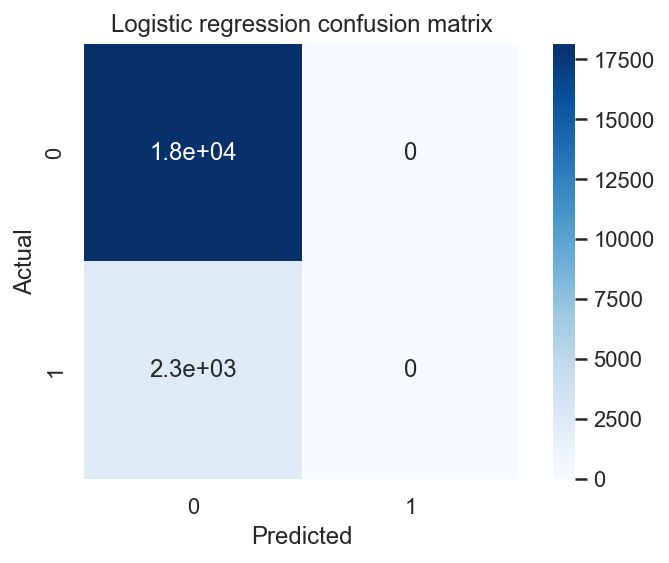

In [112]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, lr_4x.predict(X_val))
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');



# Second model (added more numerical features)

Add all numerical features:

In [748]:
# Specificy features (other than target and the patient ID):
features_model_2 = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
# Generate new dataframe for modeling:
df_model_2 = prepares_dataset_modeling(features_model_2,diabetic_data)
# 80/20 training/holdout split. 
Xy, X_test, y_test = get_patient_split_data_first_split(df_model_2)
# 75/25 train/test split (of the previous 80 split).
X_train, X_val, y_train, y_val,df_tr2 = get_patient_split_data_second_split(Xy)
del features_model_2 # 
# del df_model_1



In [638]:
forest = RandomForestClassifier(n_estimators = 100, random_state = 0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [636]:
(f1_score(y_val, forest.predict(X_val)), roc_auc_score(y_val, forest.predict_proba(X_val)[:,1]))



(0.030333670374115267, 0.5890081257338632)

In [639]:
forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0,class_weight='balanced')
forest_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [640]:
(f1_score(y_val, forest.predict(X_val)), roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))



(0.030333670374115267, 0.5817314819390226)

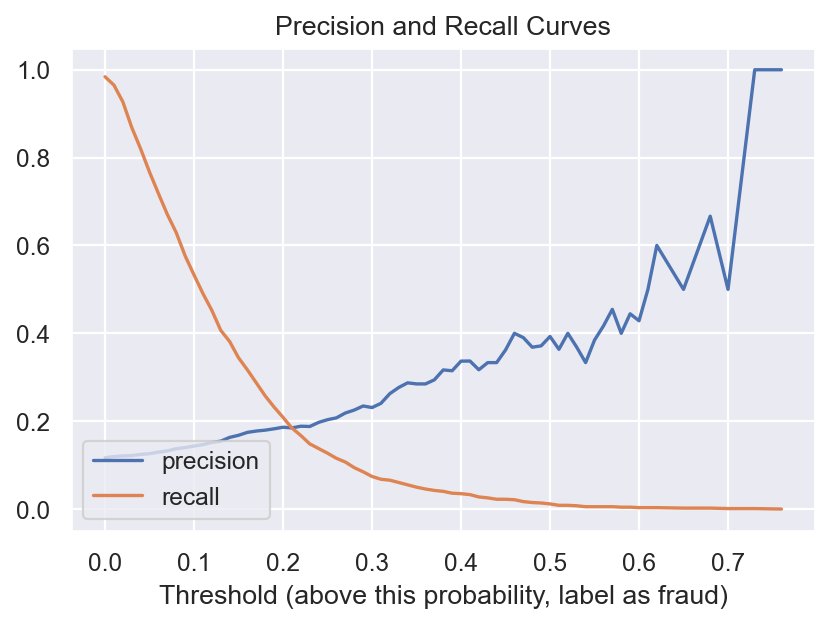

In [641]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, forest_balanced.predict_proba(X_val)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.5817314819390226


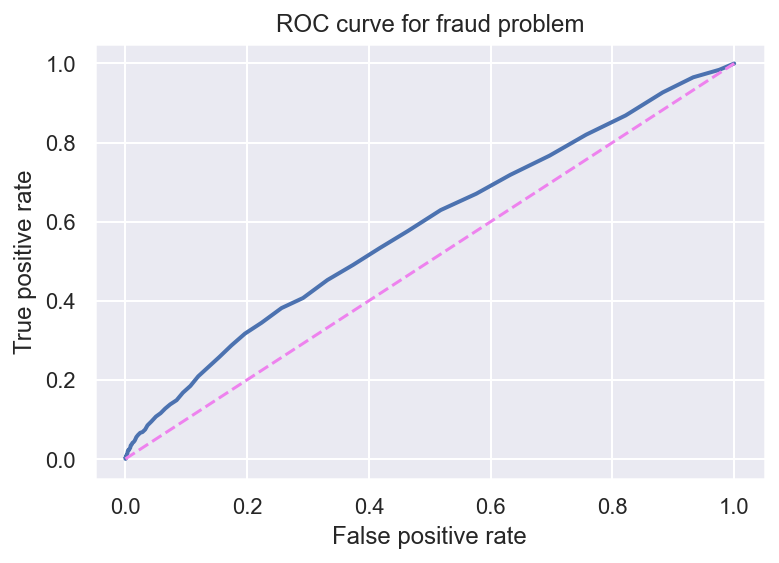

In [642]:
fpr, tpr, thresholds = roc_curve(y_val, forest_balanced.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))

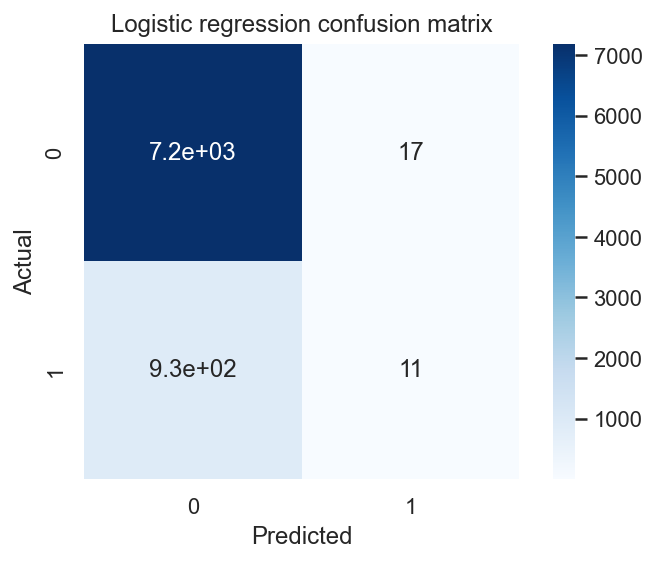

In [645]:
# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, forest_balanced.predict(X_val))
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');

second model - linear regression, standard scaler.

In [754]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train_scaled, y_train)

lr = LogisticRegression(max_iter=100)
lr.fit(X_train_scaled, y_train)
f1_score(lr.predict(X_test), y_test)

/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


0.0

### Model 2, balance, with 10-fold cross-validation without controling patients being in both the train and validation sets.

In [664]:
def get_patient_split_data_for_cv(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_patients = df['patient_nbr'].unique() 
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['patient_nbr'].isin(test_patients)]
    df_te = df[df['patient_nbr'].isin(test_patients)] 

    y_tr, y_te = df_tr['readmitted_binary_target'],df_te['readmitted_binary_target']
    X_tr = df_tr.drop(['readmitted_binary_target'],axis=1) 
    X_te = df_te.drop(['readmitted_binary_target'],axis=1)

    return X_tr,y_tr, X_te, y_te

In [628]:
from sklearn.model_selection import KFold


# Specificy features (other than target and the patient ID):
features_model_2 = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
# Generate new dataframe for modeling:
df_model_2 = prepares_dataset_modeling(features_model_2,diabetic_data)
# 80/20 training/holdout split. 
X,y,X_test, y_test = get_patient_split_data_for_cv(df_model_2)

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

#run the CV

kf = KFold(n_splits=10, shuffle=True, random_state = 71)
cv_randomForests_balanced_f1 = [] #collect the validation results for both models
cv_randomForests_balanced_roc = []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    
    forest_balanced = RandomForestClassifier(n_estimators = 100, random_state = 0,class_weight='balanced')
    forest_balanced.fit(X_train, y_train)
    
    (f1_score(y_val, forest.predict(X_val)), roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))

    
    cv_randomForests_balanced_f1.append(f1_score(y_val, forest.predict(X_val)))
    cv_randomForests_balanced_roc.append(roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))


/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/ignasisols/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature n

In [652]:
print(f'f1 cv r^2: {np.mean(cv_randomForests_balanced_f1):.3f} +- {np.std(cv_randomForests_balanced_f1):.3f}')
print(f'Roc cv r^2: {np.mean(cv_randomForests_balanced_roc):.3f} +- {np.std(cv_randomForests_balanced_roc):.3f}')




f1 cv r^2: 0.859 +- 0.009
Roc cv r^2: 0.588 +- 0.008


# Before applying balance (Model 2)

In [201]:
Xy.loc[12]

patient_nbr                 85504905
readmitted_binary_target           1
time_in_hospital                   7
num_lab_procedures                60
num_procedures                     0
num_medications                   15
number_outpatient                  0
number_emergency                   1
number_inpatient                   0
number_diagnoses                   8
Name: 12, dtype: int64

In [194]:
X_val.head(100)

patient_nbr  time_in_hospital  num_lab_procedures  num_procedures  \
3       82442376                 2                  44               1   
5       82637451                 3                  31               6   
11      77391171                 7                  62               0   
12      85504905                 7                  60               0   
14      49726791                 1                  49               5   
..           ...               ...                 ...             ...   
529       645309                 6                  75               2   
530      1591542                 3                  62               5   
532      1159938                 2                  61               5   
535      4161582                10                  32               0   
543      6564861                10                  37               3   

     num_medications  number_outpatient  number_emergency  number_inpatient  \
3                 16                  0                 0                 0   
5                 16                  0                 0                 0   
11                11                  0                 0                 0   
12                15                  0                 1                 0   
14                 2                  0                 0                 0   
..               ...                ...               ...               ...   
529               19                  0                 0                 0   
530               14                  0                 0                 0   
532               10                  0                 0                 0   
535                6                  0                 0                 0   
543               28                  0                 0                 0   

     number_diagnoses  
3                   7  
5                   9  
11                  7  
12                  8  
14                  8  
..                ...  
529                 6  
530                 7  
532                 7  
535                 4  
543                 7  

[100 rows x 9 columns]

In [200]:
X_val.loc[12]

patient_nbr           85504905
time_in_hospital             7
num_lab_procedures          60
num_procedures               0
num_medications             15
number_outpatient            0
number_emergency             1
number_inpatient             0
number_diagnoses             8
Name: 12, dtype: int64

In [199]:
y_val.loc[12]

1

In [183]:
values, counts = np.unique(y_train, return_counts=True)
print(values,counts,counts[1]/sum(counts))

[0 1] [54155  6919] 0.11328879719684318


In [182]:
values, counts = np.unique(y_val, return_counts=True)
print(values,counts,counts[1]/sum(counts))

[0 1] [18135  2269] 0.11120368555185257


In [184]:
values, counts = np.unique(y_test, return_counts=True)
print(values,counts,counts[1]/sum(counts))

[0 1] [18119  2169] 0.10691048895899054


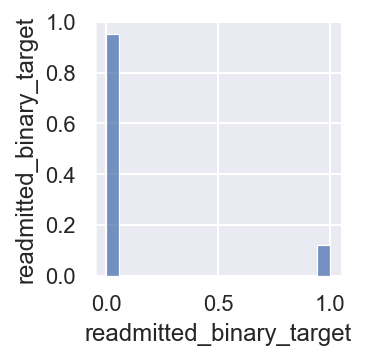

In [177]:
sns.pairplot(pd.DataFrame(y_train))

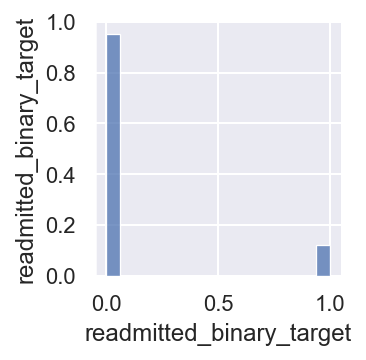

In [162]:
sns.pairplot(pd.DataFrame(y_val))

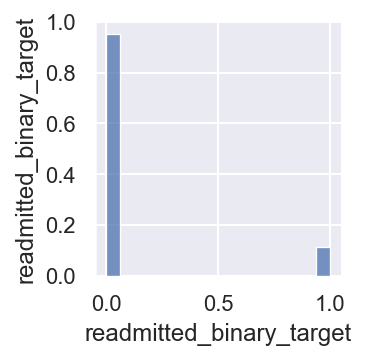

In [163]:
sns.pairplot(pd.DataFrame(y_test))

In [167]:
y_test.nunique()

2

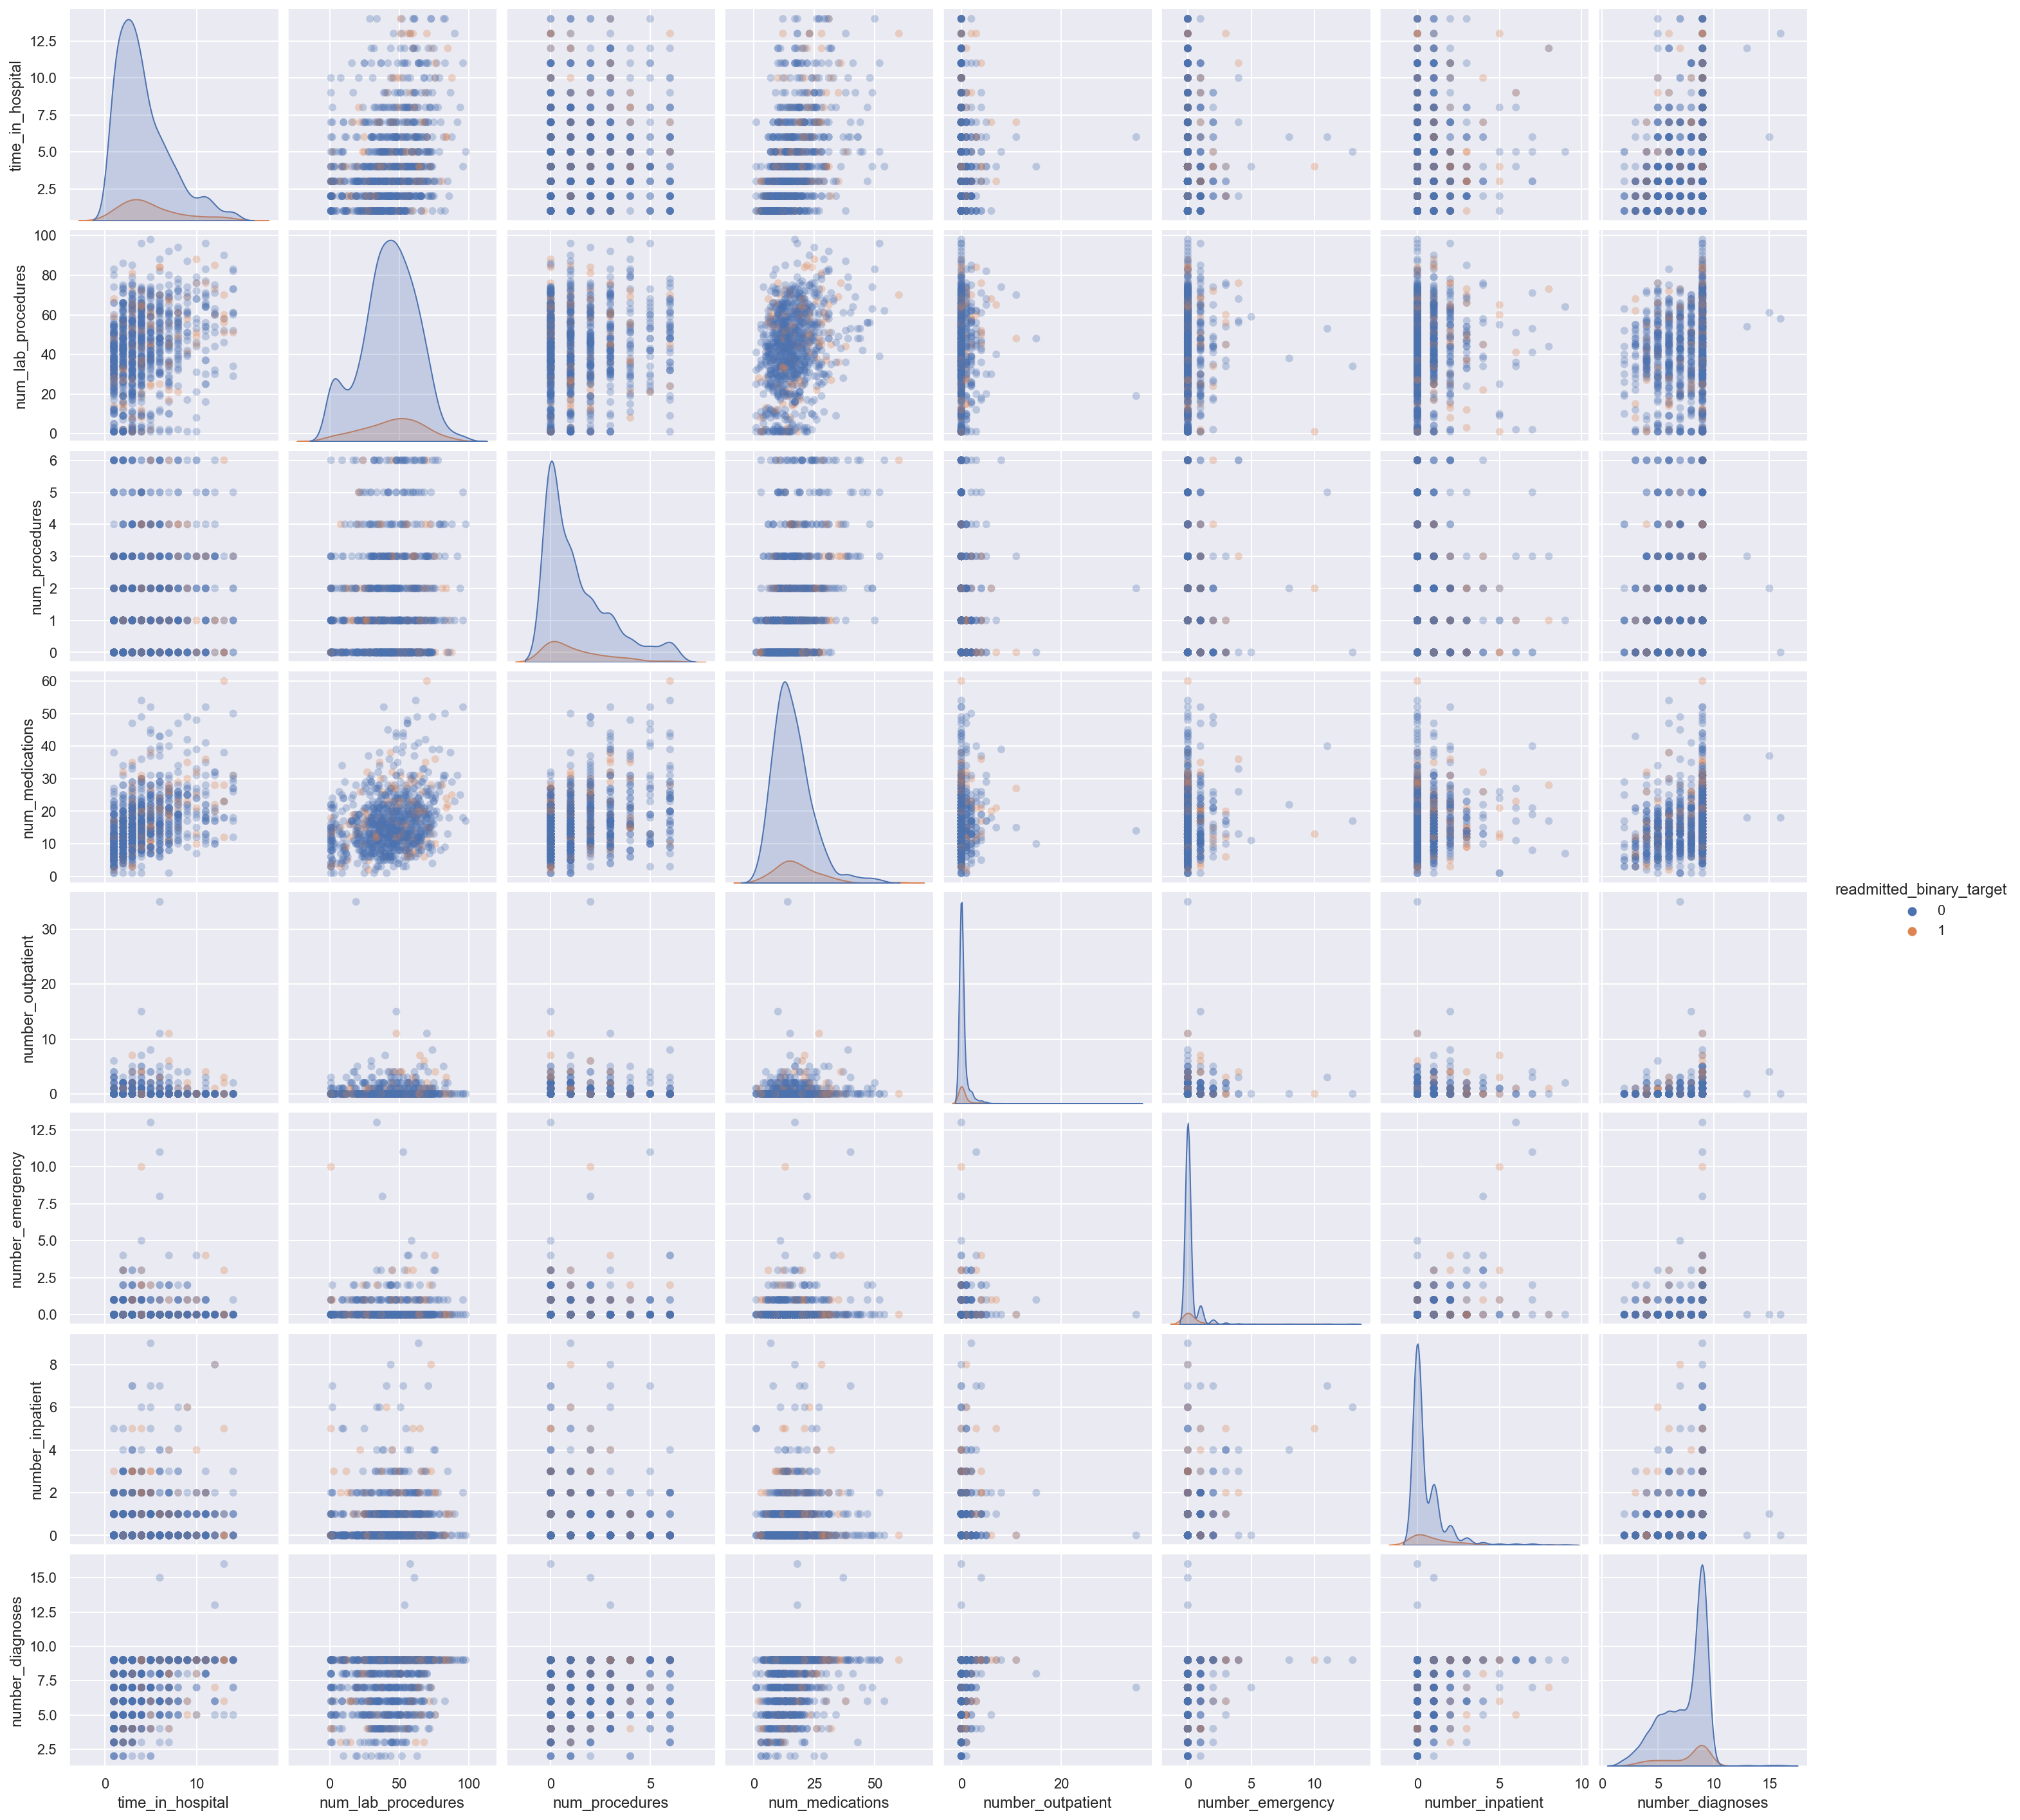

In [123]:
plot_features(df_tr2)

In [151]:
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train, y_train)
# f1_score(lr.predict(X_test), y_test)
lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, lr_balanced.predict(X_val)), roc_auc_score(y_val, lr_balanced.predict_proba(X_val)[:,1])))


Balanced class weights Logistic Regression Test F1: 0.200, Test AUC: 0.503


In [152]:
f1_score(y_train, lr_balanced.predict(X_train))

0.20352095068610002

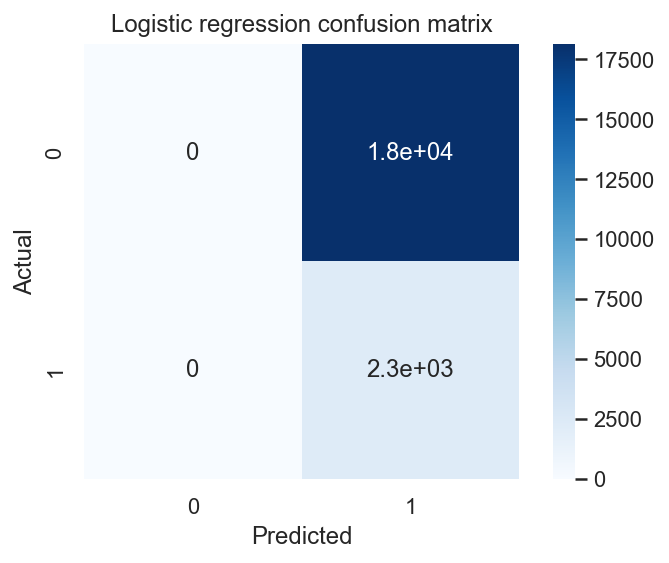

In [127]:

# Print confusion matrix for logistic regression
logit_confusion = confusion_matrix(y_val, lr_balanced.predict(X_val))
sns.heatmap(logit_confusion, cmap=plt.cm.Blues, annot=True, square=True) # ,xticklabels=df_model_1['target_names'],yticklabels=df_model_1['target_names']

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');

# Exploring categorical features

In [228]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 51 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [527]:
def barplot_categorical_features(categorical_feature):
    data = diabetic_data.groupby(['race'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()

    sns.barplot(x=categorical_feature, y="mean", data=data)
    plt.title(categorical_feature, size = 20) #Add plot title
    plt.ylabel("average_target")
    plt.xlabel("categories")
    plt.ylim(0,0.65)


In [535]:
def count_categorical_features(categorical_feature):
    data = diabetic_data.groupby(['race'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()
    data['count'] = (data['count']/data['count'].sum()*100)
    data.rename(columns={'count':'percentage'},inplace = True)
    ax = sns.barplot(x=categorical_feature, y="percentage", data=data)
    ax.axhline(5.0)
    plt.title(categorical_feature, size = 20) #Add plot title
    plt.ylabel('percentage(%)')
    plt.xlabel("categories")

In [266]:
features_list = pd.Series(diabetic_data.columns)
features_list

0                 encounter_id
1                  patient_nbr
2                         race
3                       gender
4                          age
5                       weight
6            admission_type_id
7     discharge_disposition_id
8          admission_source_id
9             time_in_hospital
10                  payer_code
11           medical_specialty
12          num_lab_procedures
13              num_procedures
14             num_medications
15           number_outpatient
16            number_emergency
17            number_inpatient
18                      diag_1
19                      diag_2
20                      diag_3
21            number_diagnoses
22               max_glu_serum
23                   A1Cresult
24                   metformin
25                 repaglinide
26                 nateglinide
27              chlorpropamide
28                 glimepiride
29               acetohexamide
30                   glipizide
31                   glyburide
32      

diagnose 1

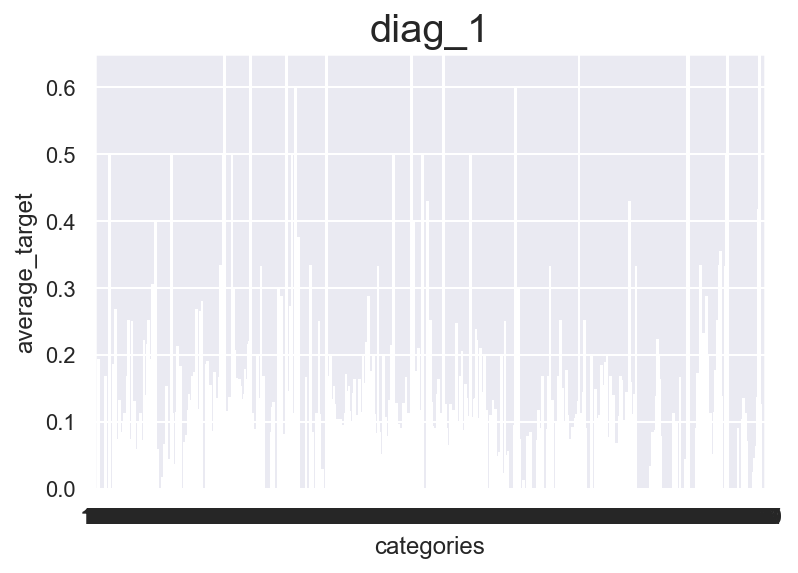

In [428]:
barplot_categorical_features(features_list[18])

In [551]:
def percentage_counts(row):
    return row/sumCount*100

In [588]:
data = diabetic_data.groupby(['diag_1'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()
sumCount = data['count'].sum()

data['count'] = data['count'].apply(percentage_counts) 
data.rename(columns = {'count': 'percentage'},inplace = True)
data.sort_values('percentage',ascending=False,inplace=True)
data.head(20)

diag_1      mean  percentage
276    428  0.141067    6.744312
263    414  0.090412    6.468131
540    786  0.072460    3.947123
259    410  0.103210    3.552017
325    486  0.089510    3.447835
275    427  0.091106    2.718561
329    491  0.126154    2.235982
501    715  0.099954    2.114109
475    682  0.089618    2.006978
282    434  0.162229    1.993218
534    780  0.094601    1.984373
693    996  0.134215    1.933265
143    276  0.136051    1.856602
236     38  0.110782    1.659050
121  250.8  0.106548    1.651187
417    599  0.107210    1.567645
405    584  0.132895    1.493931
708    V57  0.135046    1.186299
119  250.6  0.185123    1.162711
348    518  0.098655    1.095877

In [568]:
data[(data['percentage']>=5.0)]['mean'].mean()

0.11573926795521813

In [571]:
data[(data['percentage']<=5.0)]['mean'].mean()

0.09969002652883233

In [597]:
data[(data['mean']>=0.2)]['percentage'].sum()

1.7031581674855252

In [598]:
data = diabetic_data.groupby(['diag_2'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()
sumCount = data['count'].sum()

data['count'] = data['count'].apply(percentage_counts) 
data.rename(columns = {'count': 'percentage'},inplace = True)
data.sort_values('percentage',ascending=False,inplace=True)
data.head(20)

diag_2      mean  percentage
133     276  0.119964    6.658252
261     428  0.126388    6.569501
78      250  0.073464    5.986707
260     427  0.111795    4.966078
239     401  0.071734    3.684127
318     496  0.111346    3.259112
397     599  0.112835    3.242348
241     403  0.151966    2.783804
249     414  0.083019    2.613206
246     411  0.097038    2.530372
80   250.02  0.106557    2.045204
464     707  0.142571    1.971245
386     585  0.145377    1.845022
385     584  0.115221    1.626104
313     491  0.130097    1.523548
79   250.01  0.128693    1.501854
142     285  0.092763    1.498896
509     780  0.098592    1.470298
258     425  0.122036    1.414090
444     682  0.132589    1.413104

diag_2      mean  percentage
133     276  0.119964    6.658252
261     428  0.126388    6.569501
78      250  0.073464    5.986707
260     427  0.111795    4.966078
239     401  0.071734    3.684127
318     496  0.111346    3.259112
397     599  0.112835    3.242348
241     403  0.151966    2.783804
249     414  0.083019    2.613206
246     411  0.097038    2.530372
80   250.02  0.106557    2.045204
464     707  0.142571    1.971245
386     585  0.145377    1.845022
385     584  0.115221    1.626104
313     491  0.130097    1.523548
79   250.01  0.128693    1.501854
142     285  0.092763    1.498896
509     780  0.098592    1.470298
258     425  0.122036    1.414090
444     682  0.132589    1.413104

In [574]:
data[(data['percentage']>=5.0)]['mean'].mean()

0.10660564537694502

In [575]:
data[(data['percentage']<=5.0)]['mean'].mean()

0.08945538889723918

In [602]:
data[(data['mean']>=0.2)]['percentage'].sum()

2.1536762385610606

In [603]:
data = diabetic_data.groupby(['diag_3'])['readmitted_binary_target'].agg(['mean', 'count']).reset_index().copy()
sumCount = data['count'].sum()

data['count'] = data['count'].apply(percentage_counts) 
data.rename(columns = {'count': 'percentage'},inplace = True)
data.sort_values('percentage',ascending=False,inplace=True)
data.head(20)

diag_3      mean  percentage
86      250  0.085158   11.515502
246     401  0.083002    8.260666
139     276  0.116522    5.157310
268     428  0.122351    4.561355
267     427  0.116056    3.941481
256     414  0.092249    3.651475
326     496  0.134357    2.596095
248     403  0.163343    2.348943
395     585  0.168675    1.985191
135     272  0.068563    1.962269
407     599  0.123132    1.934365
770     V45  0.095032    1.384252
88   250.02  0.131483    1.364320
479     707  0.148529    1.355351
529     780  0.111694    1.329440
148     285  0.105833    1.195898
265     425  0.115317    1.132117
108   250.6  0.177778    1.076308
264     424  0.102540    1.059366
394     584  0.131880    0.959708

In [578]:
data[(data['percentage']<=5.0)]['mean'].mean()

0.10905139671091389

In [614]:
data[(data['mean']>=0.2)]['percentage'].sum()

1.7031581674855252

In [757]:
# count_categorical_features(features_list[18])

diagnose 2

In [758]:
# barplot_categorical_features(features_list[19])

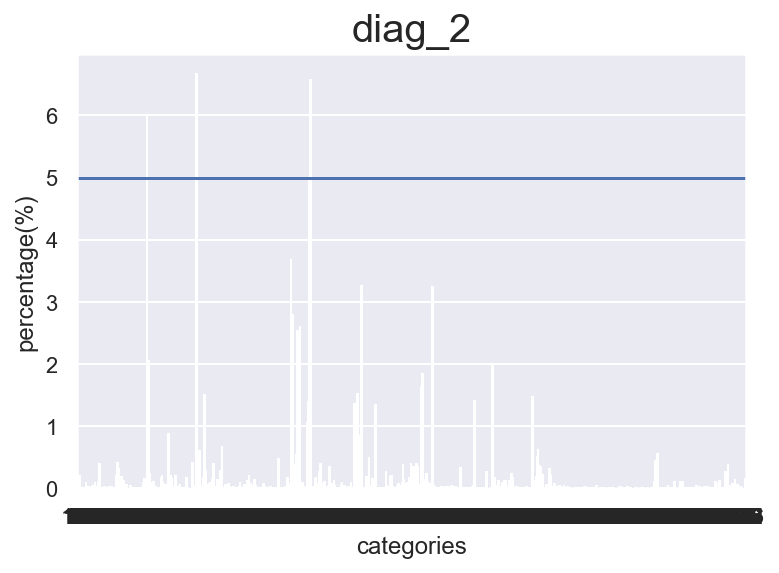

In [437]:
count_categorical_features(features_list[19])

Diagnose 3

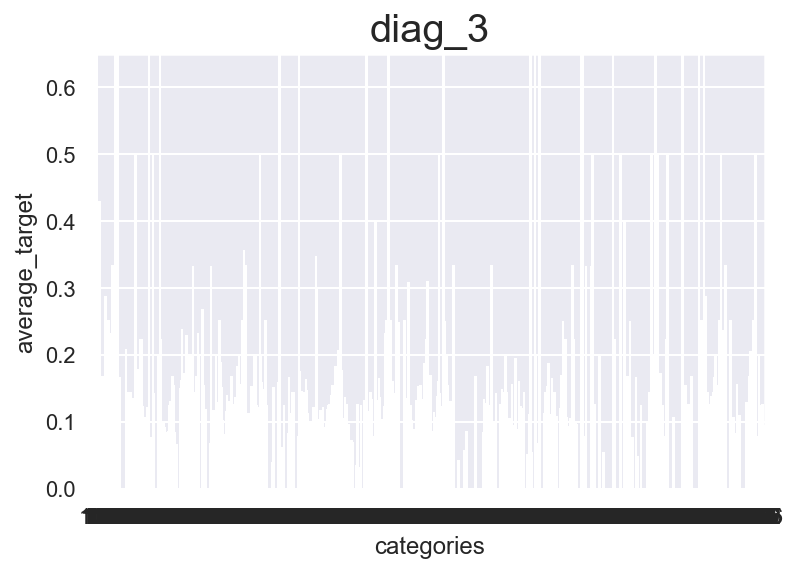

In [432]:
barplot_categorical_features(features_list[20])

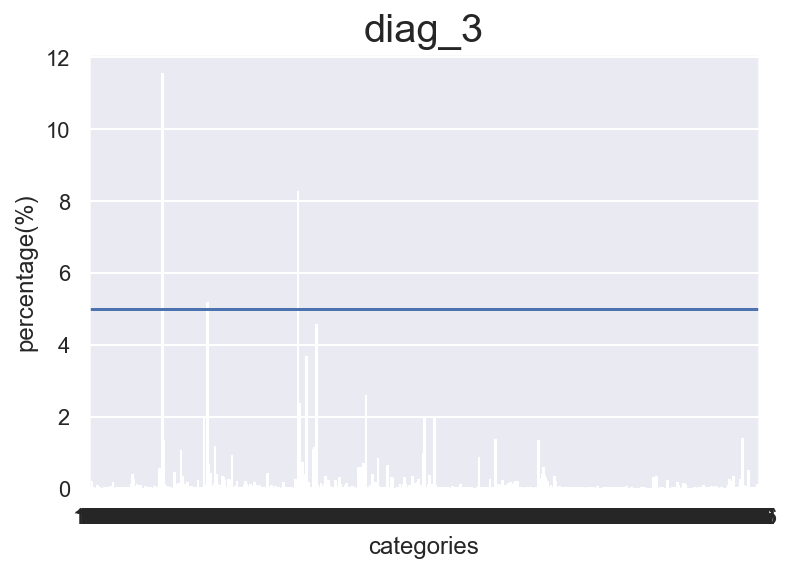

In [438]:
count_categorical_features(features_list[20])

Race

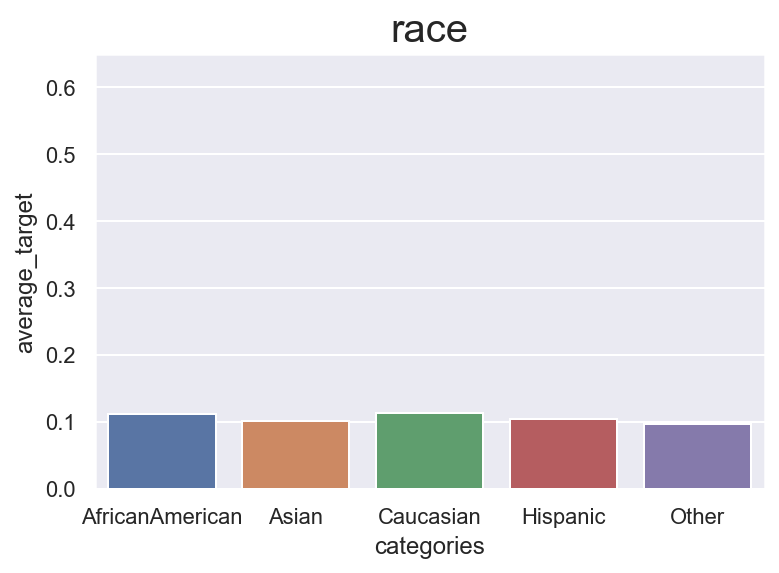

In [593]:
barplot_categorical_features(features_list[2])

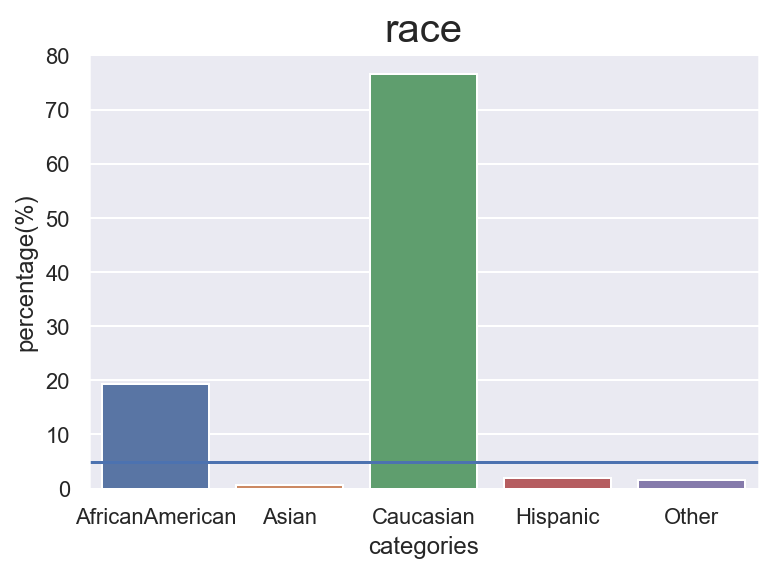

In [594]:
count_categorical_features(features_list[2])

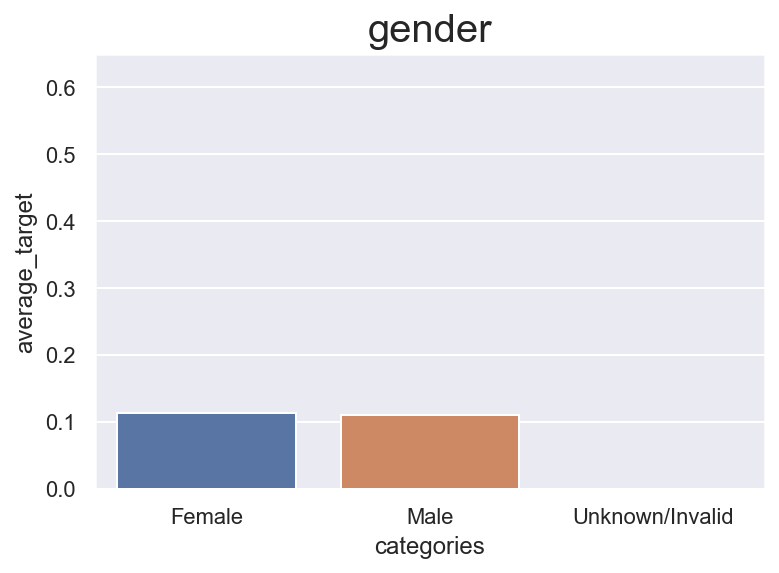

In [512]:
barplot_categorical_features(features_list[3])

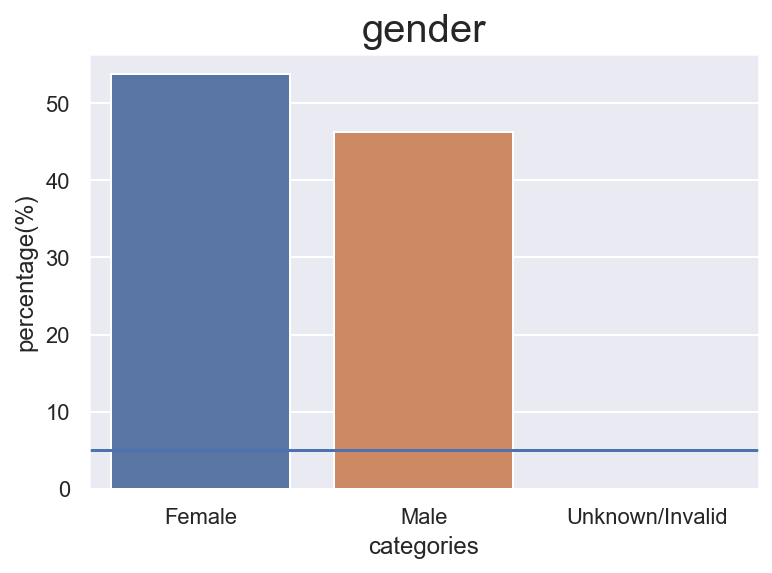

In [520]:
count_categorical_features(features_list[3])

AGE

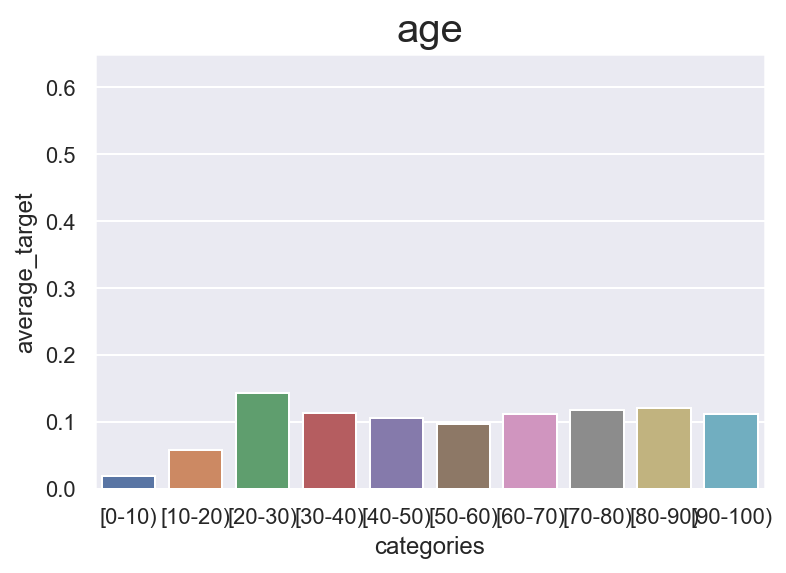

In [513]:
barplot_categorical_features(features_list[4])

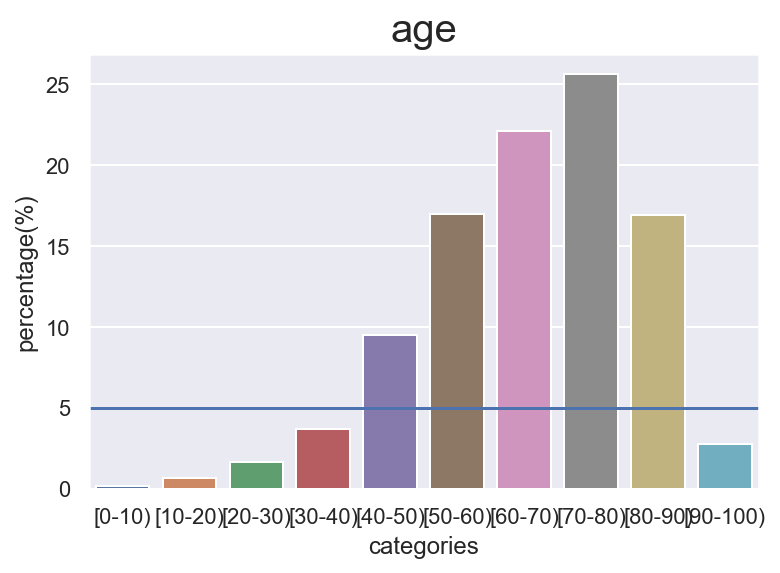

In [514]:
count_categorical_features(features_list[4])

Weight

In [359]:
diabetic_data['weight'].fillna('None',inplace = True)


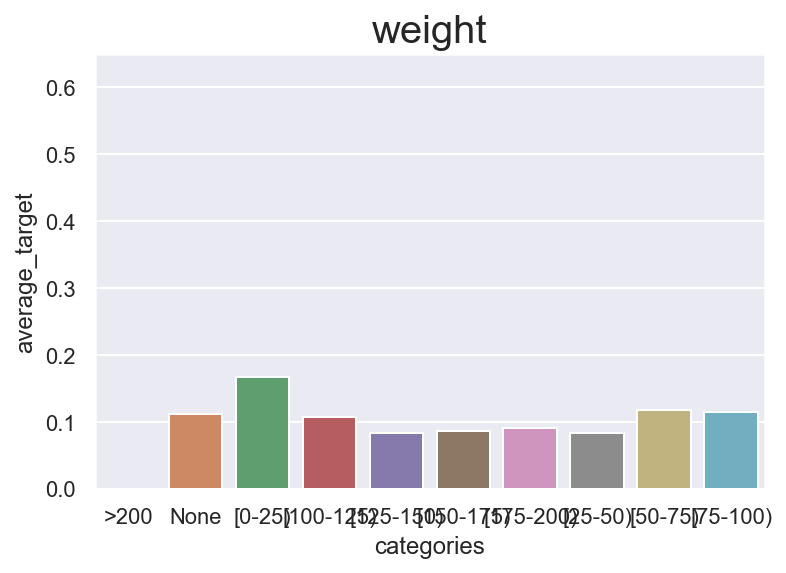

In [360]:
barplot_categorical_features(features_list[5])

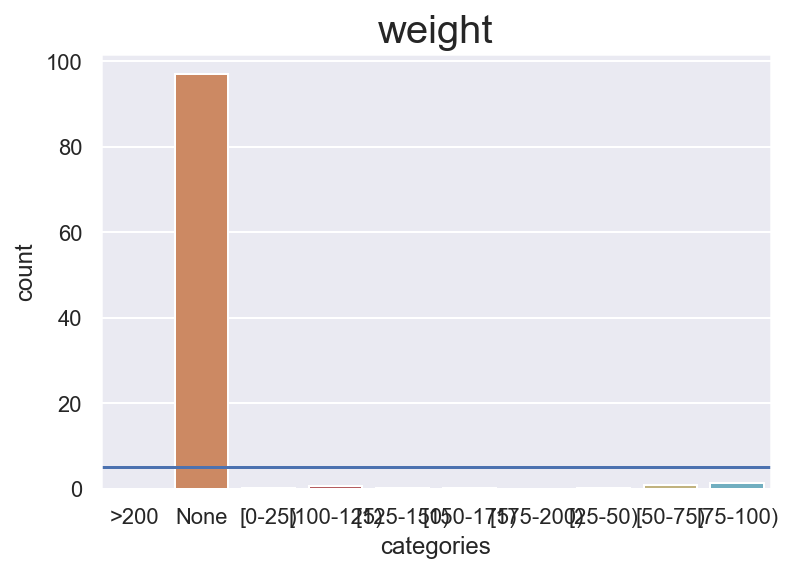

In [382]:
count_categorical_features(features_list[5])

Admission type

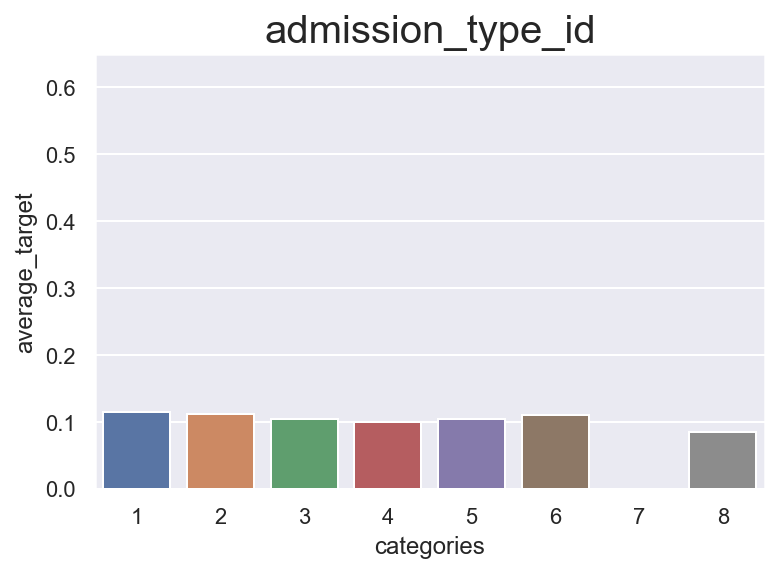

In [364]:
barplot_categorical_features(features_list[6]) 

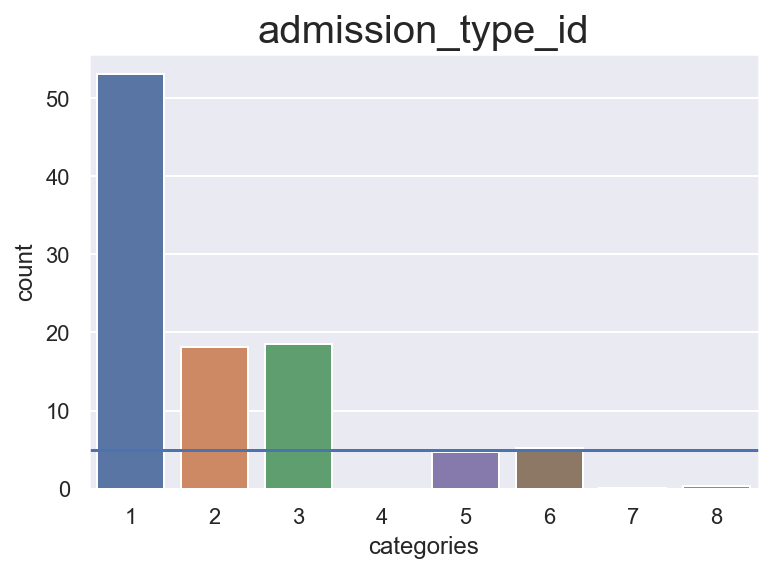

In [383]:
count_categorical_features(features_list[6])

Discharge disposition

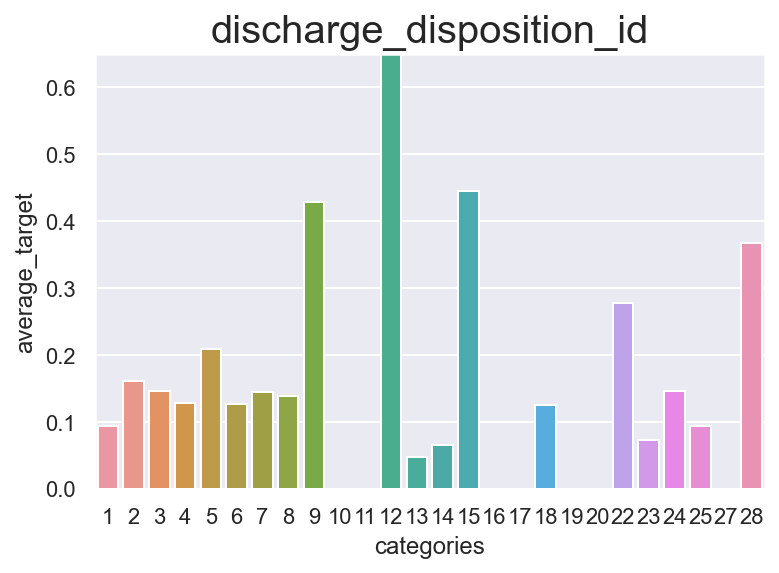

In [305]:
barplot_categorical_features(features_list[7]) 

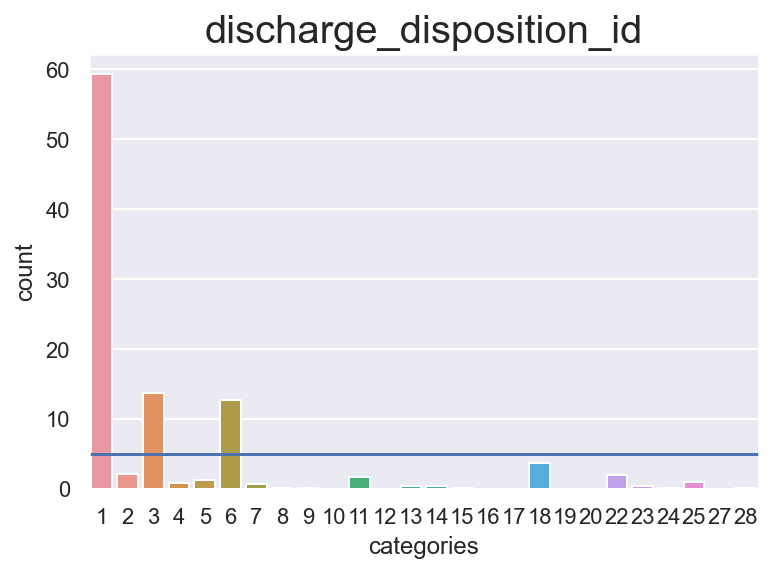

In [384]:
count_categorical_features(features_list[7])

Source ID

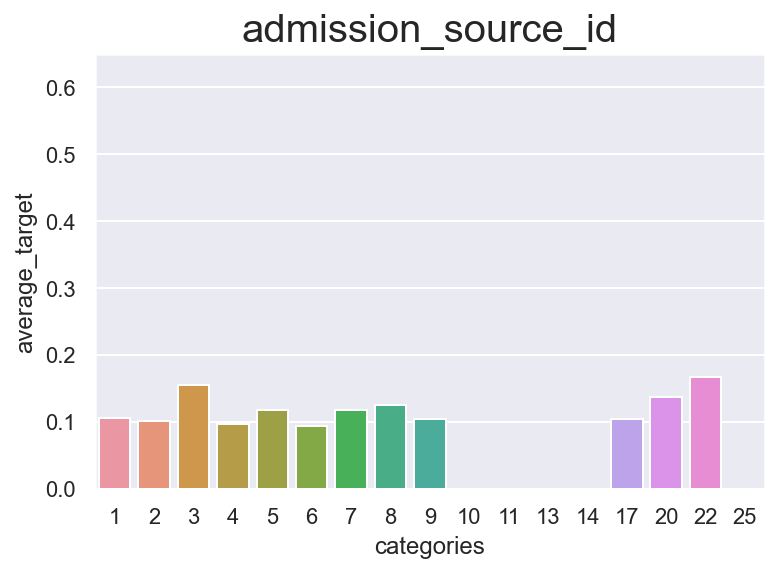

In [306]:
barplot_categorical_features(features_list[8]) 

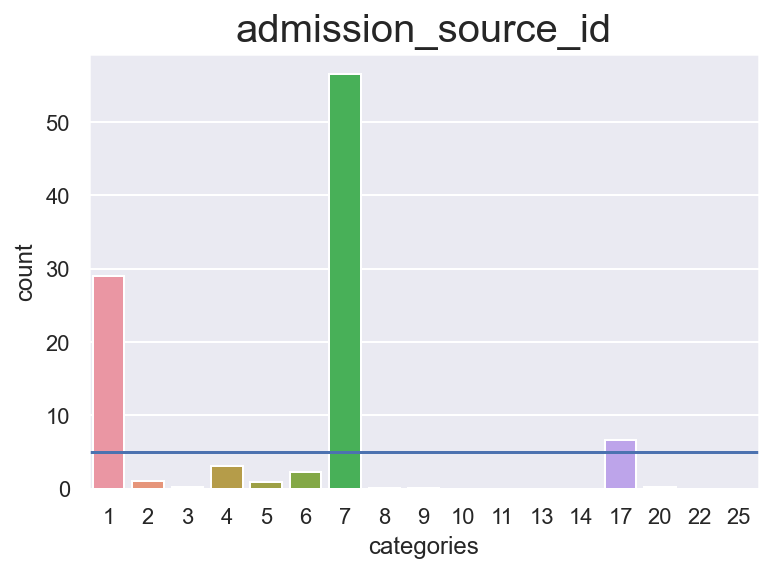

In [385]:
count_categorical_features(features_list[8])

Time in Hospital

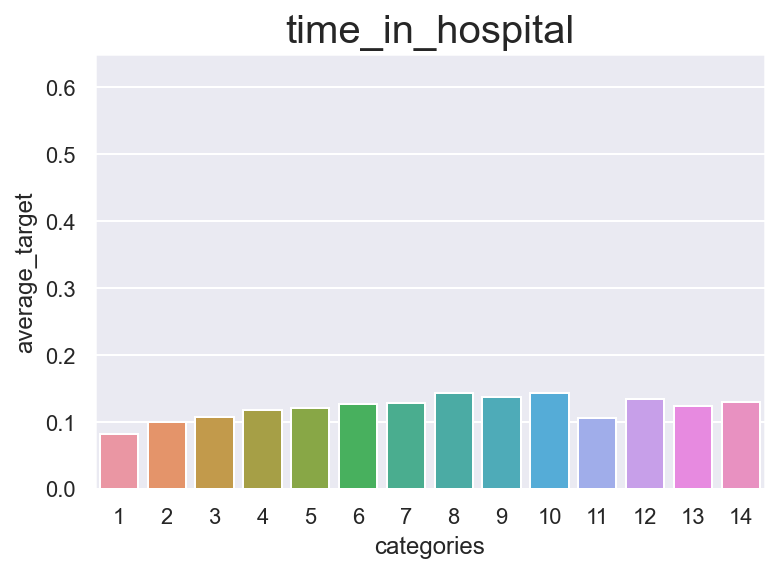

In [307]:
barplot_categorical_features(features_list[9]) 

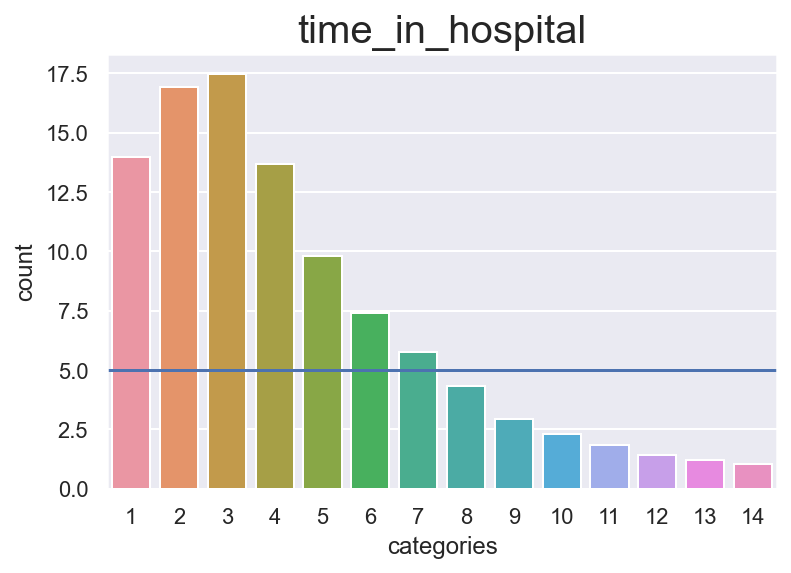

In [386]:
count_categorical_features(features_list[9])

Payer code

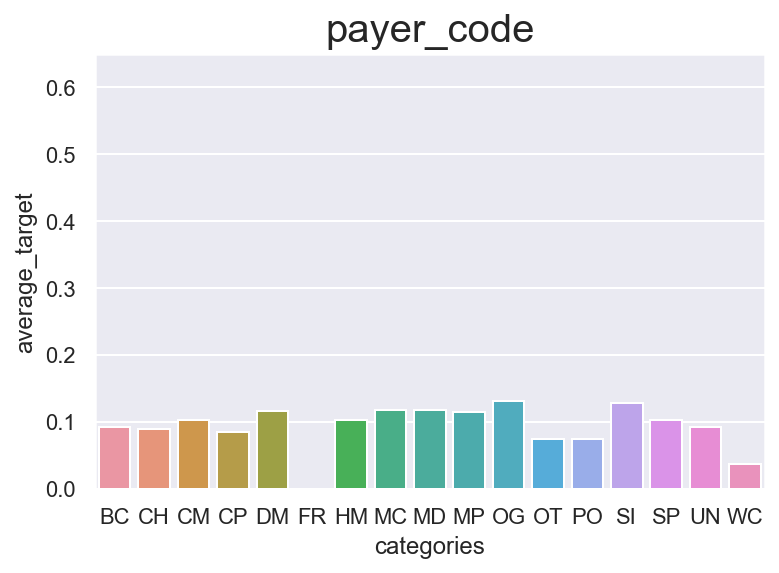

In [308]:
barplot_categorical_features(features_list[10]) 

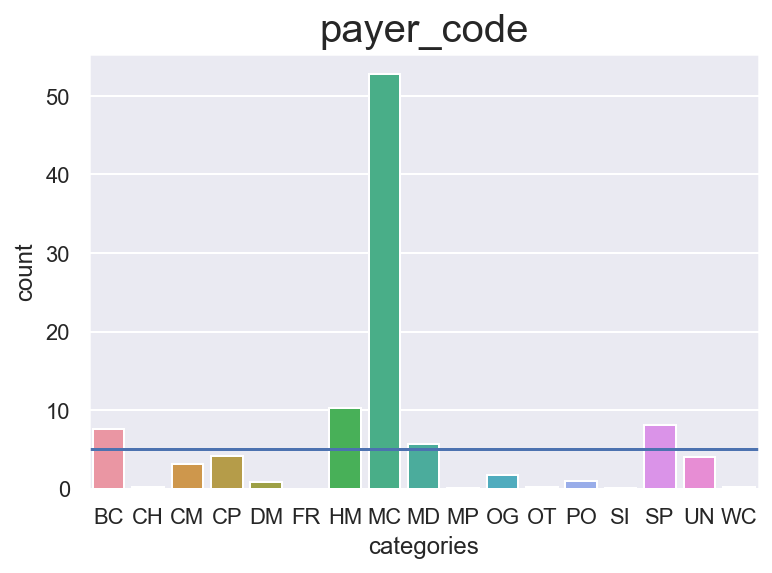

In [387]:
count_categorical_features(features_list[10])

Medical speciality

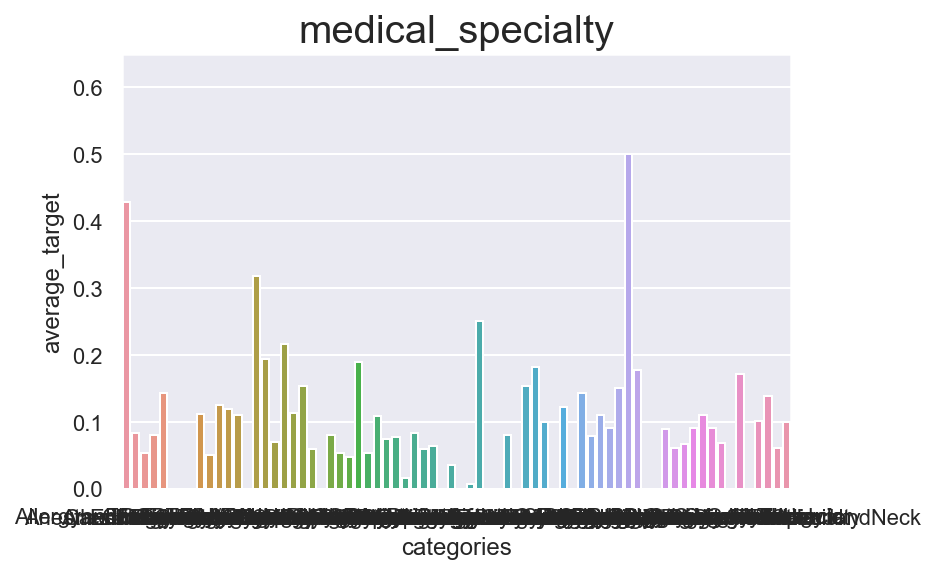

In [309]:
barplot_categorical_features(features_list[11]) 

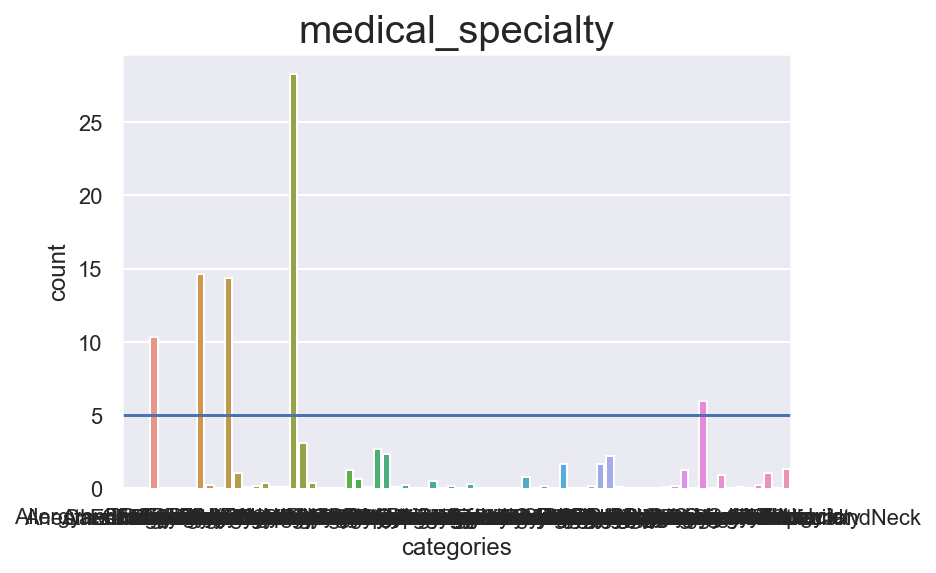

In [388]:
count_categorical_features(features_list[11])

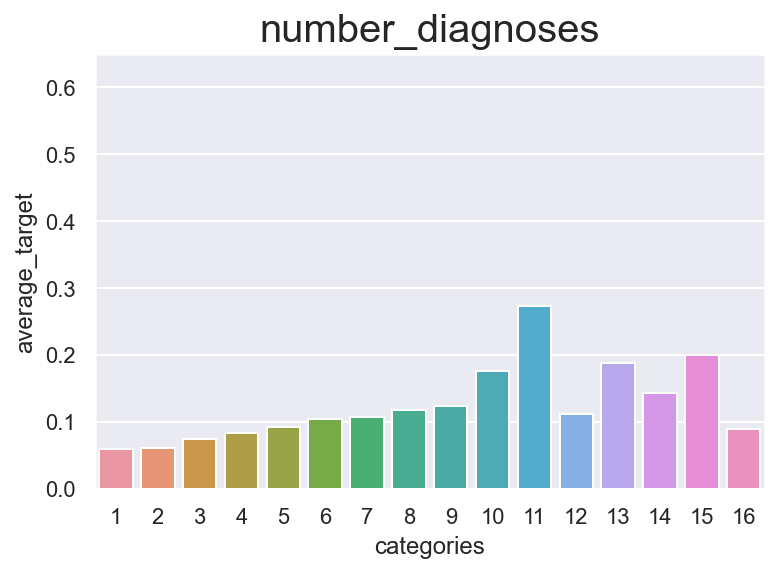

In [310]:
barplot_categorical_features(features_list[21]) 

max_glu_serum

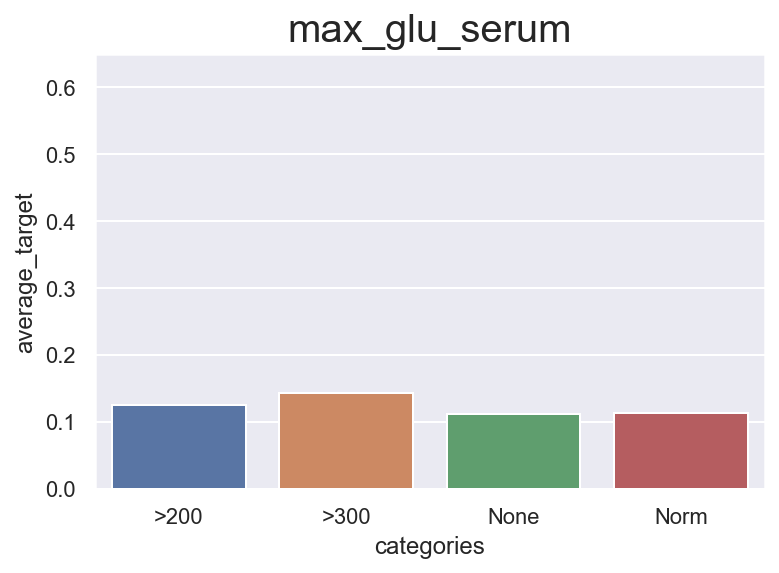

In [311]:
barplot_categorical_features(features_list[22]) 

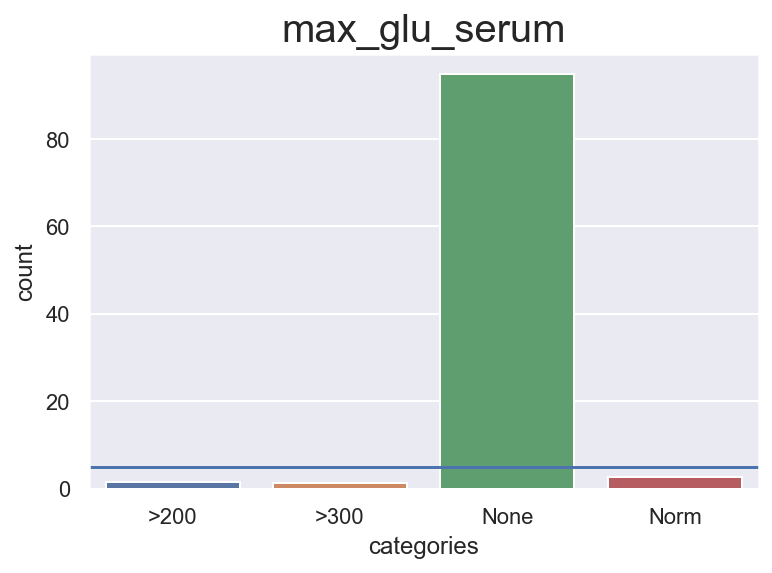

In [389]:
count_categorical_features(features_list[22]) 

A1Cresult

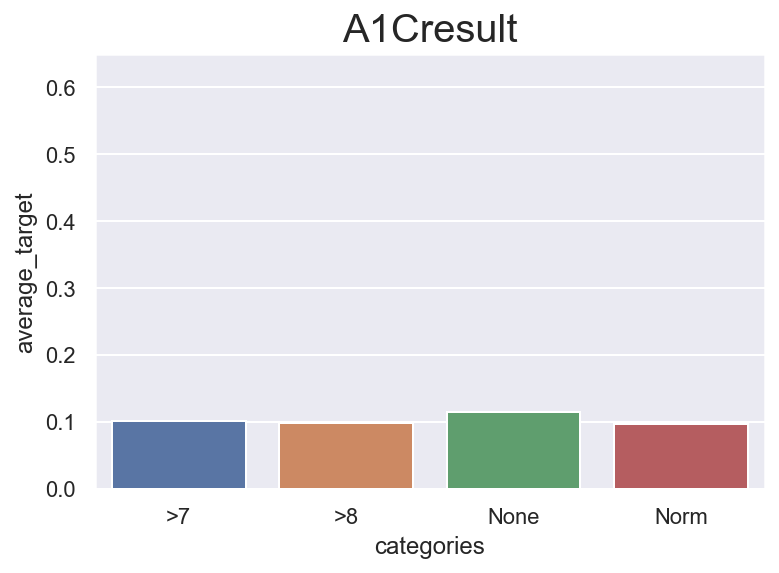

In [312]:
barplot_categorical_features(features_list[23]) 

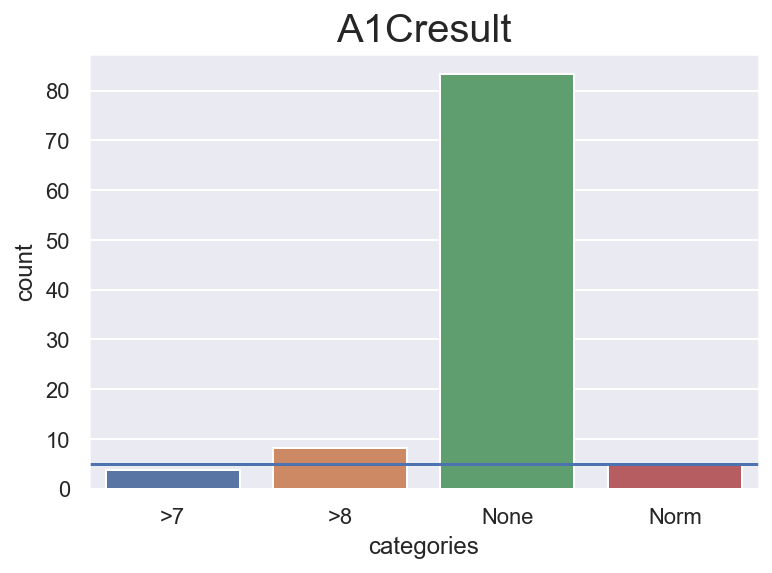

In [391]:
count_categorical_features(features_list[23])

Metformin

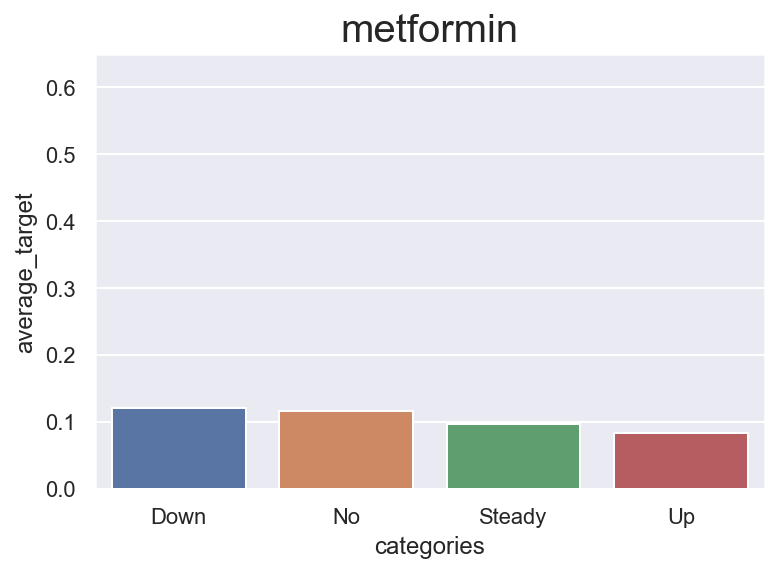

In [392]:
barplot_categorical_features(features_list[24]) 

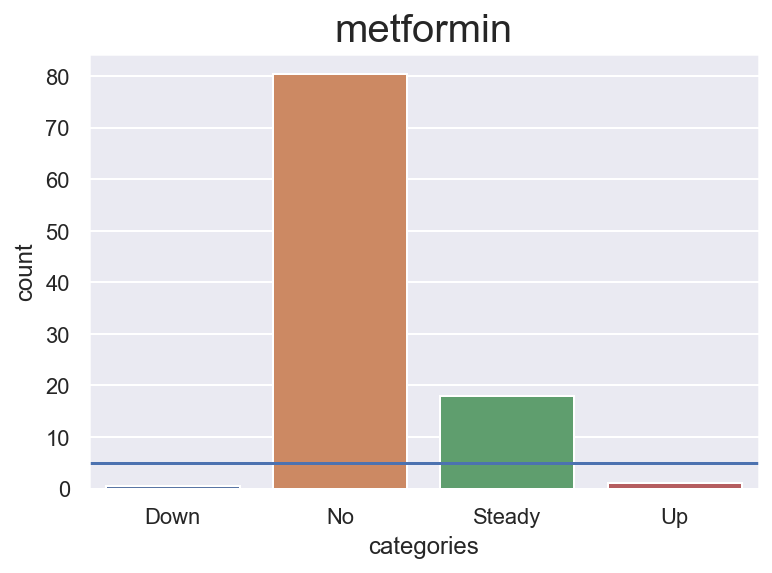

In [393]:
count_categorical_features(features_list[24]) 

replaglinide

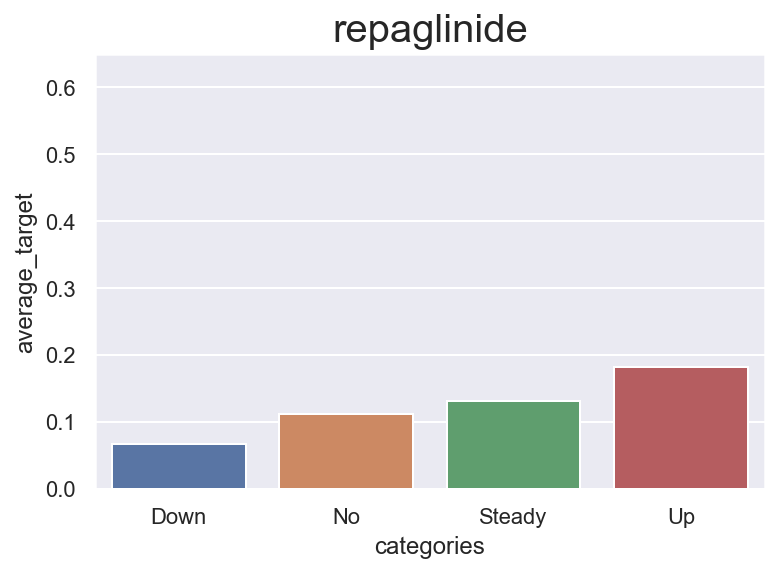

In [394]:
barplot_categorical_features(features_list[25]) 

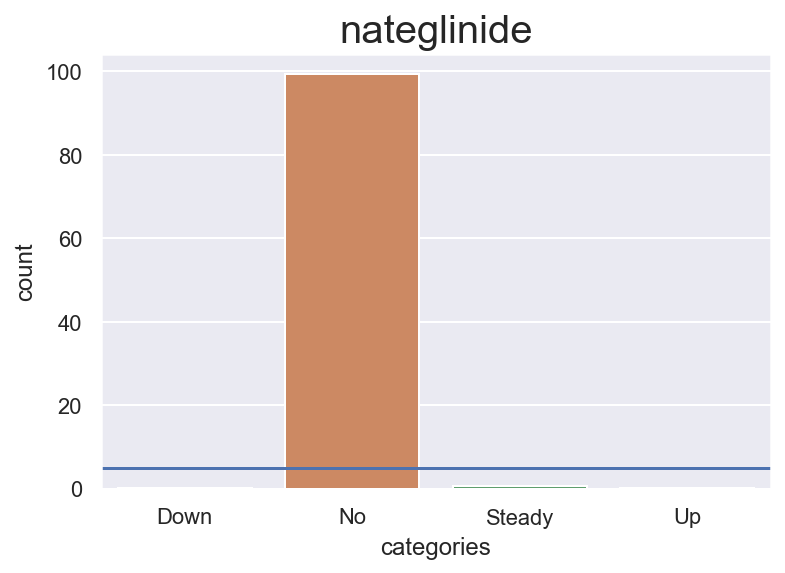

In [396]:
count_categorical_features(features_list[26]) 

cholorpropamide

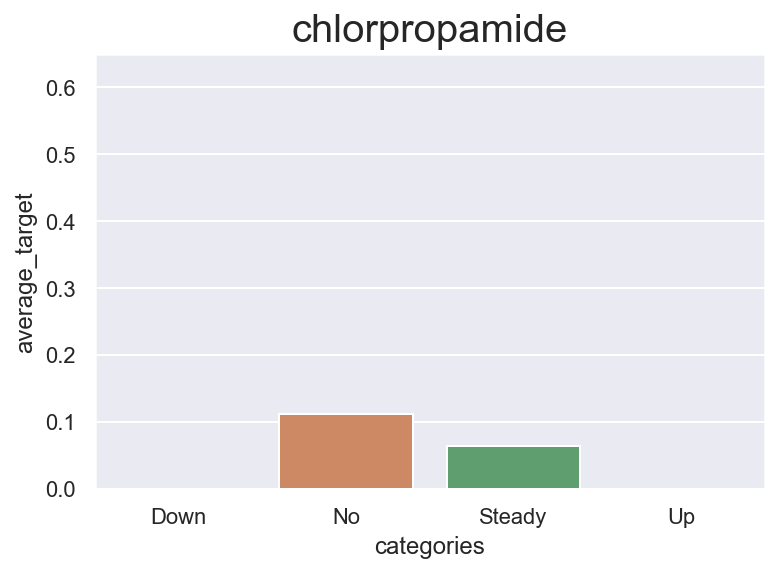

In [316]:
barplot_categorical_features(features_list[27]) 

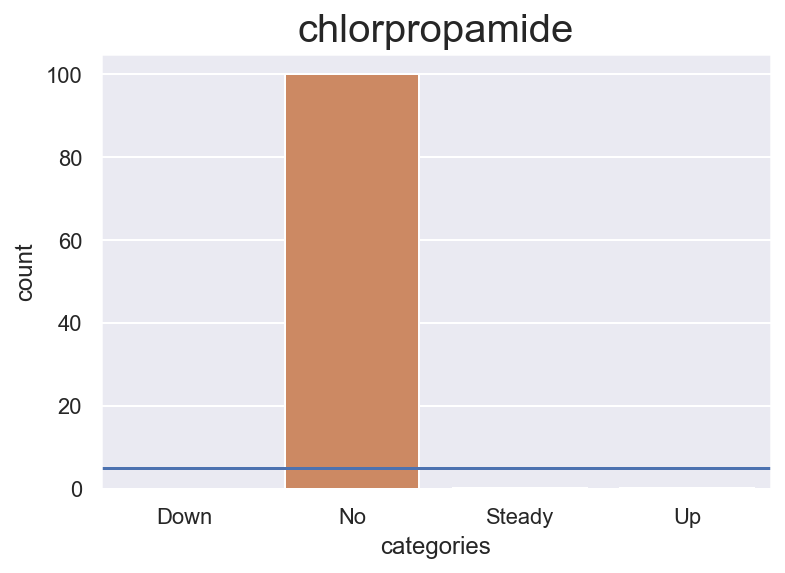

In [398]:
count_categorical_features(features_list[27]) 

Glimepiride

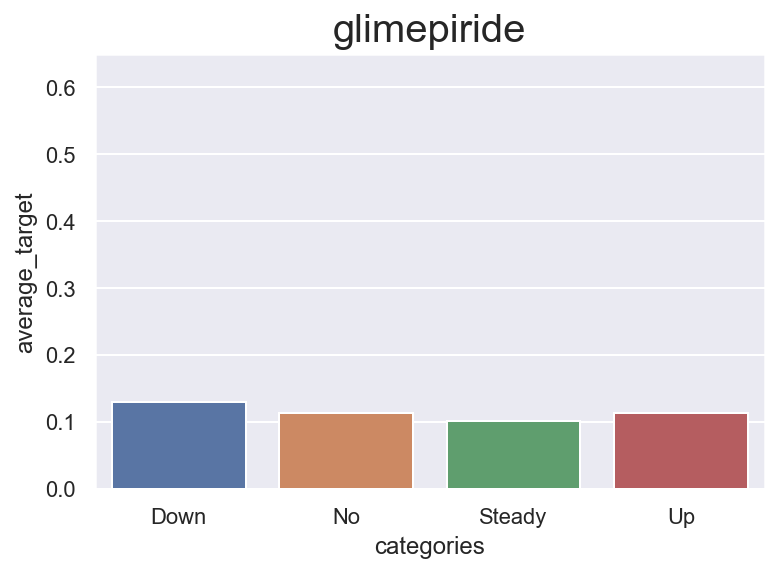

In [318]:
barplot_categorical_features(features_list[28]) 

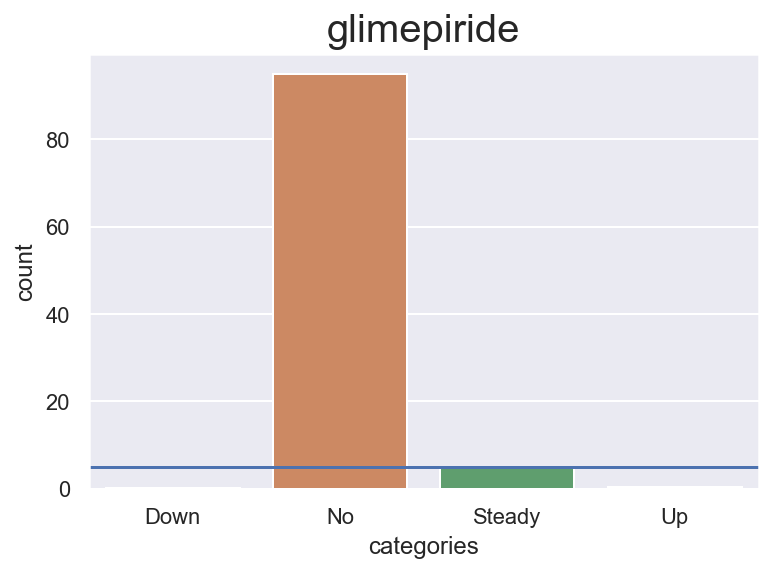

In [399]:
count_categorical_features(features_list[28]) 

Acetohexamide

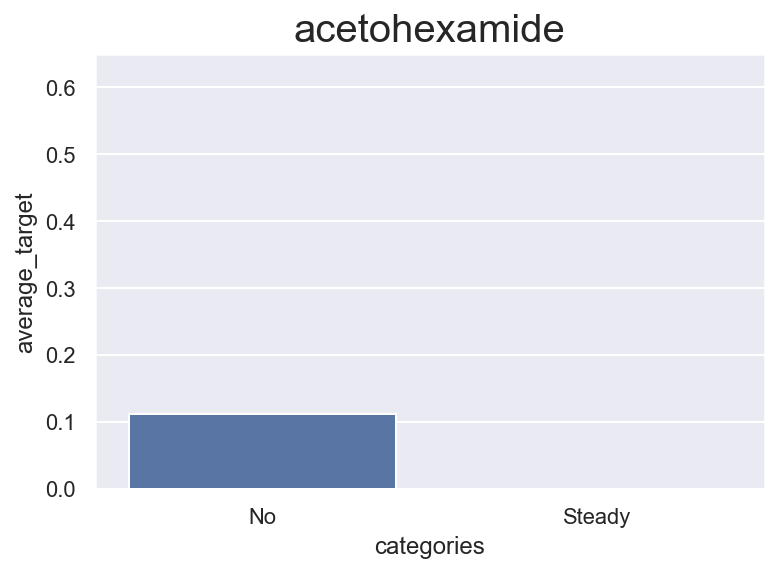

In [400]:
barplot_categorical_features(features_list[29]) 

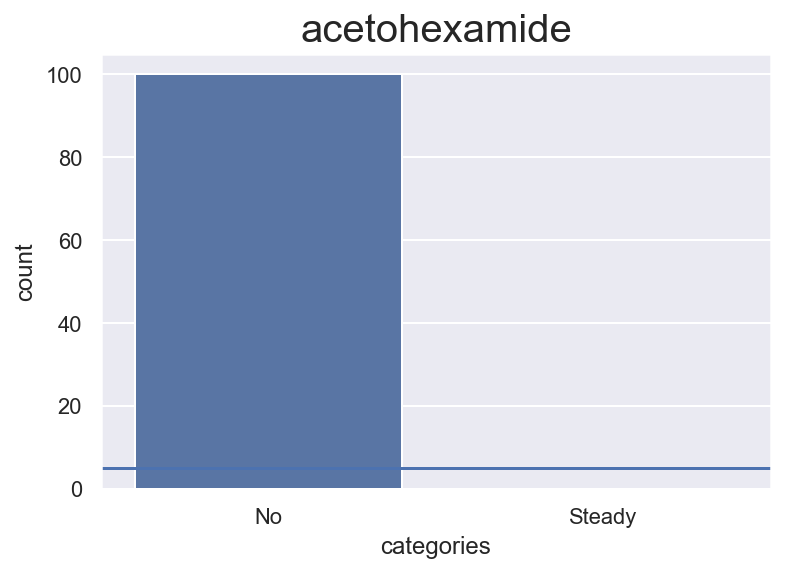

In [401]:
count_categorical_features(features_list[29]) 

Glipizide

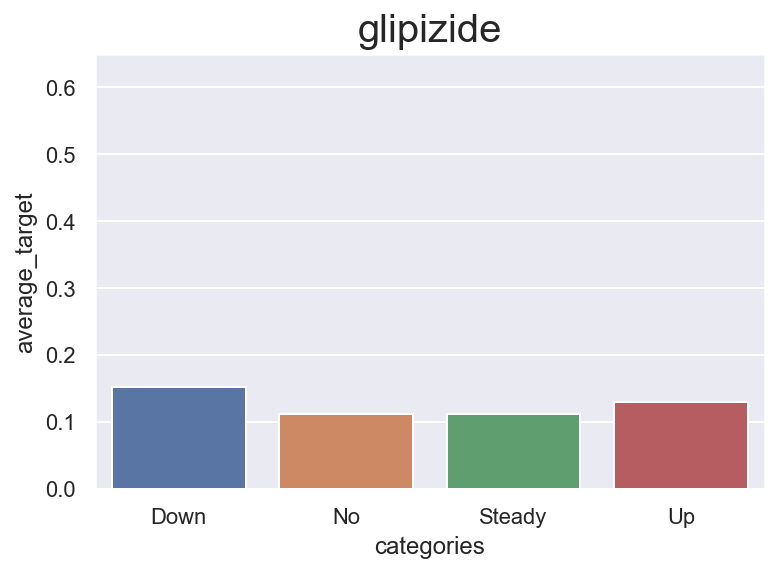

In [320]:
barplot_categorical_features(features_list[30]) 

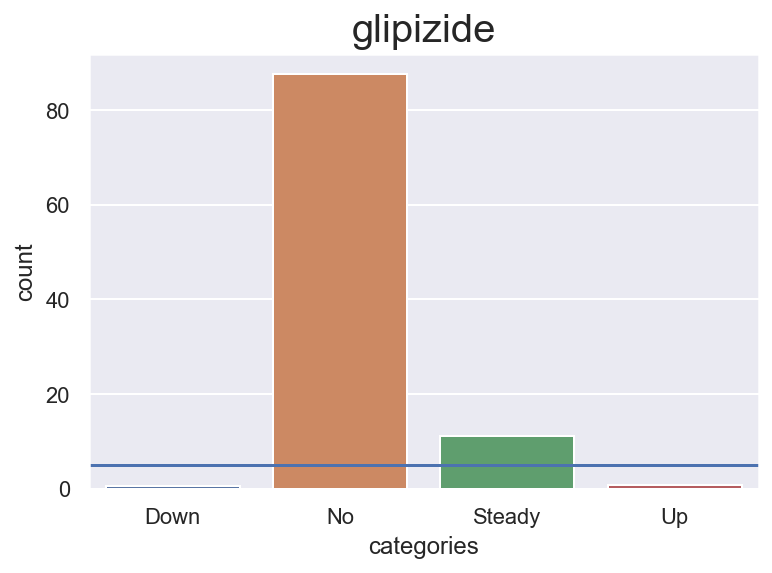

In [402]:
count_categorical_features(features_list[30]) 

Glyburide

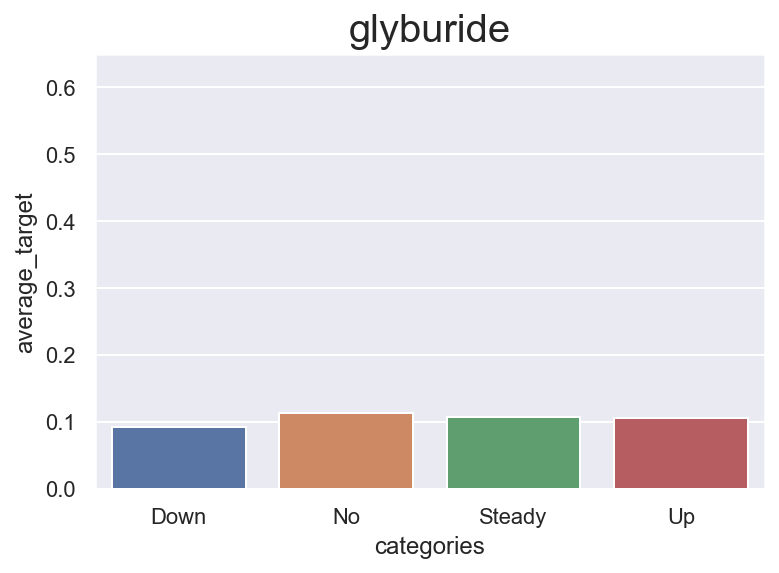

In [403]:
barplot_categorical_features(features_list[31]) 

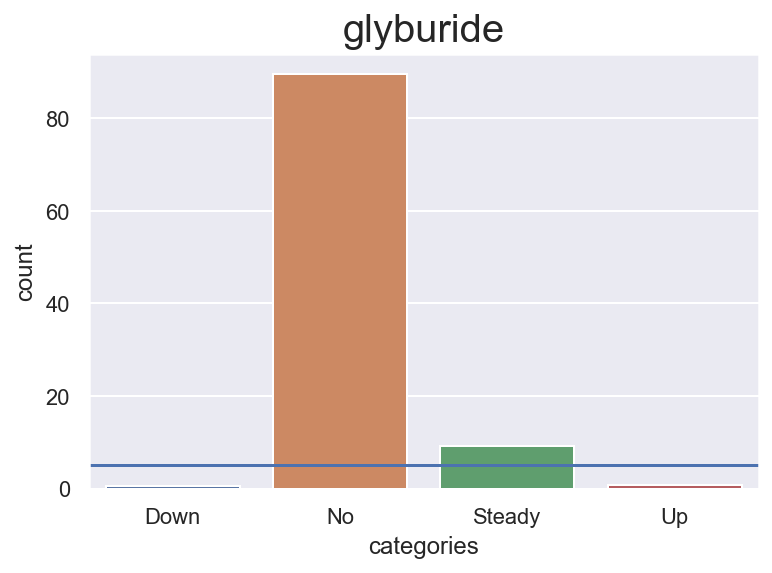

In [404]:
count_categorical_features(features_list[31]) 

Tolbutamide

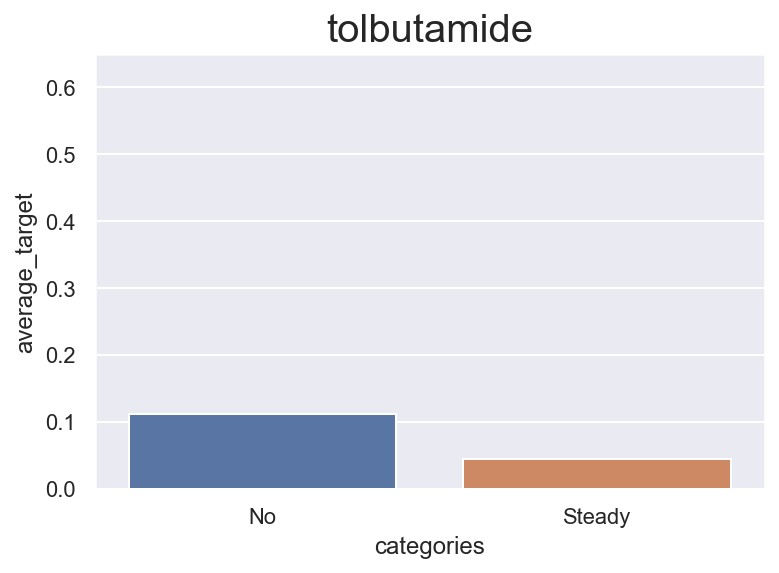

In [405]:
barplot_categorical_features(features_list[32]) 

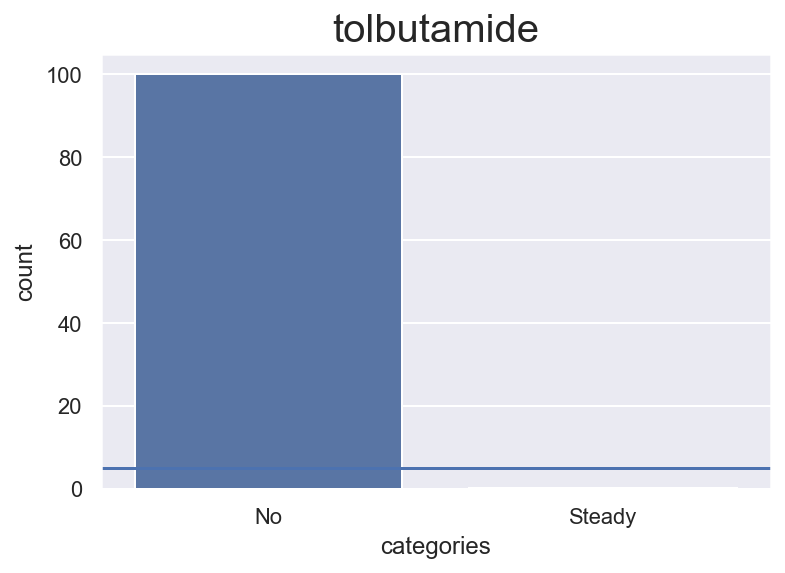

In [406]:
count_categorical_features(features_list[32]) 

Pioglitazone

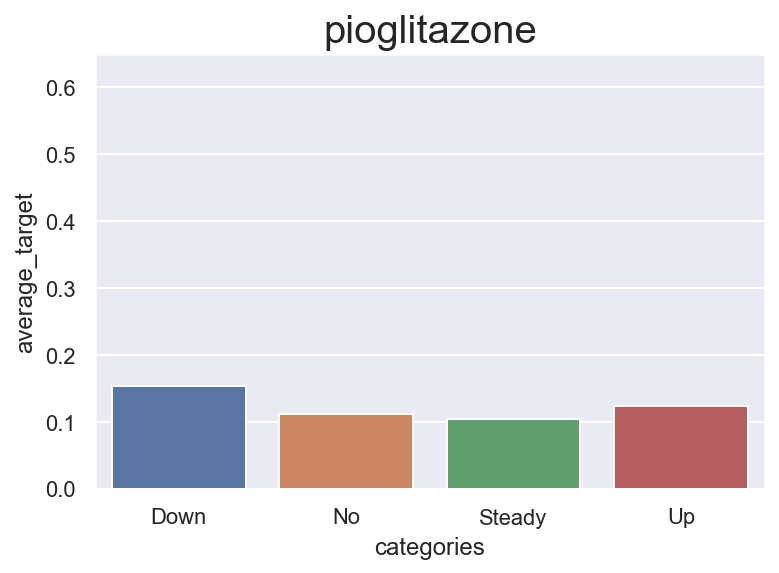

In [407]:
barplot_categorical_features(features_list[33]) 

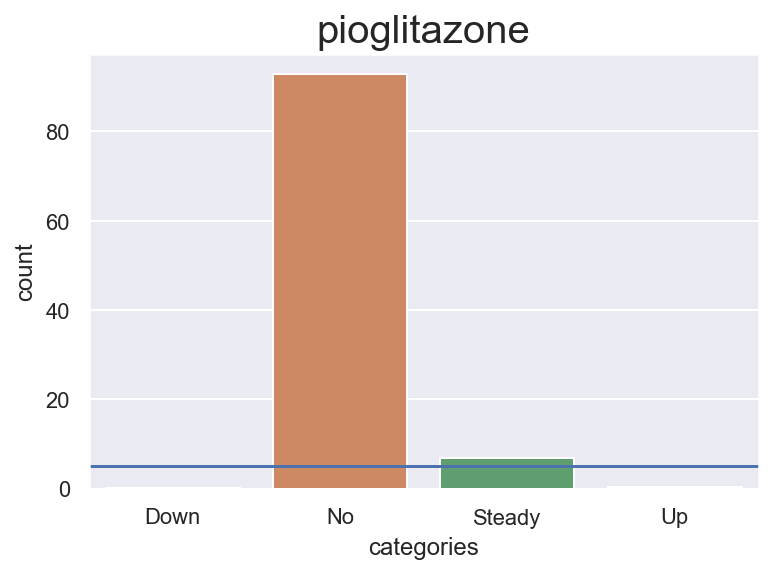

In [409]:
count_categorical_features(features_list[33]) 

Rosiglitazone

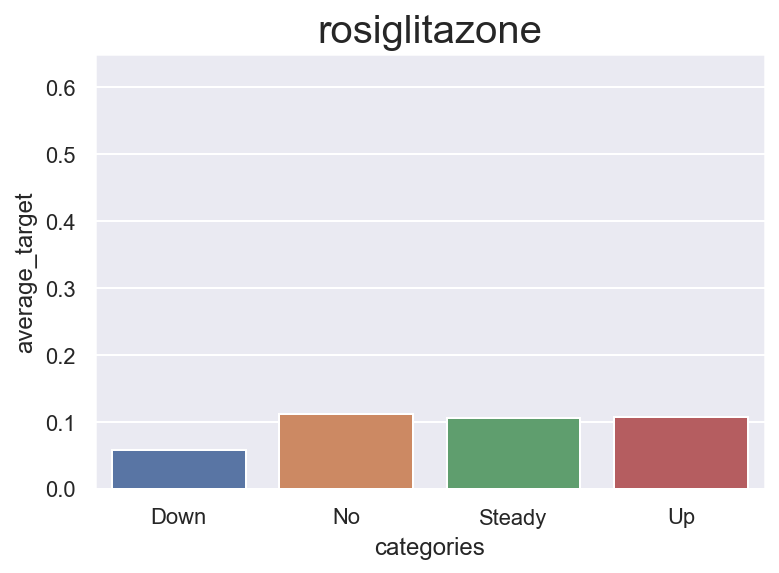

In [410]:
barplot_categorical_features(features_list[34]) 

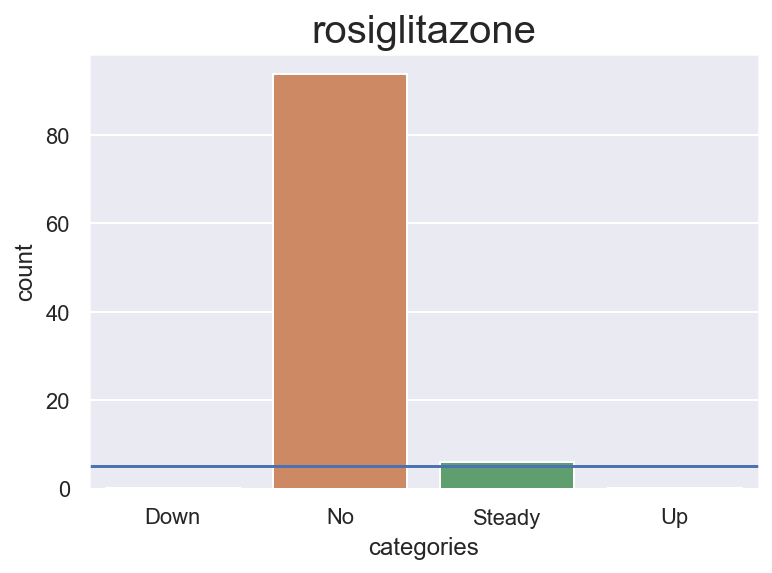

In [411]:
count_categorical_features(features_list[34]) 

acarbose

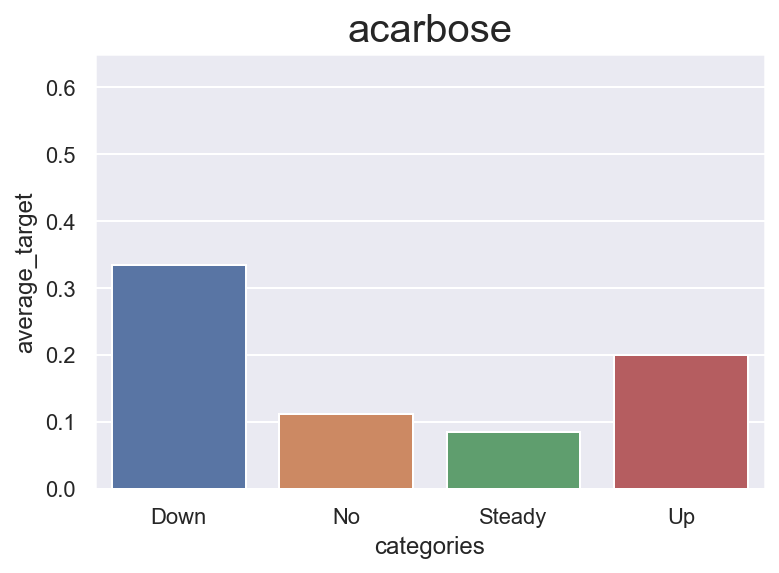

In [412]:
barplot_categorical_features(features_list[35])

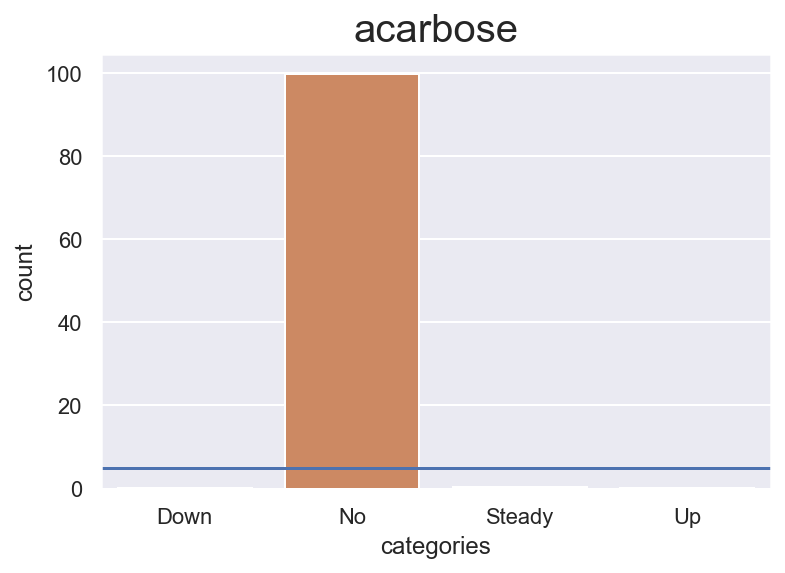

In [413]:
count_categorical_features(features_list[35]) 

miglitol

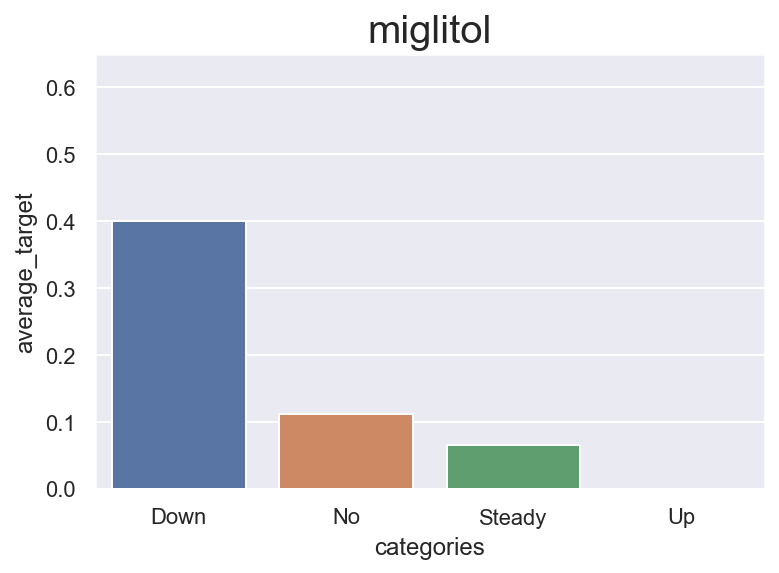

In [326]:
barplot_categorical_features(features_list[36]) 

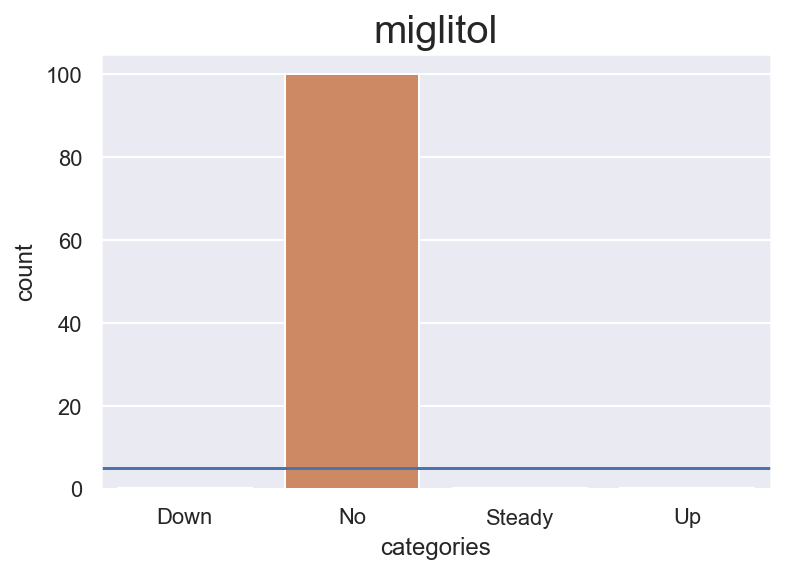

In [415]:
count_categorical_features(features_list[36]) 

Troglitazone

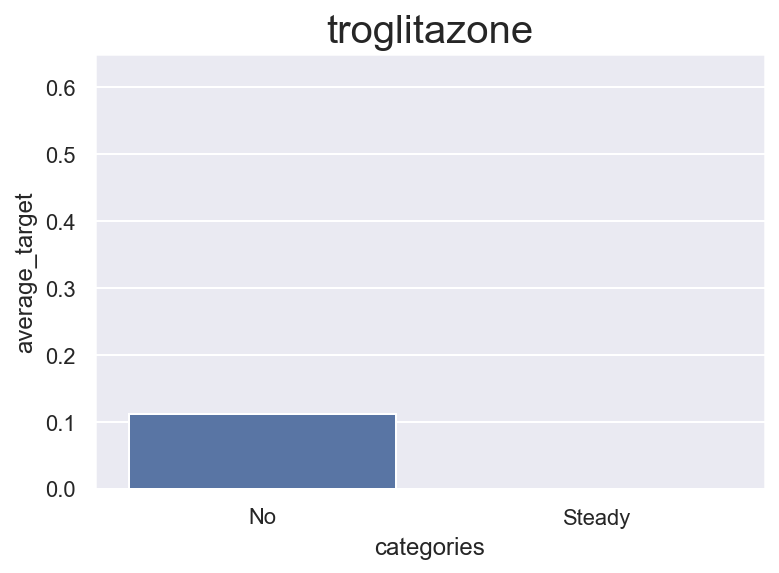

In [327]:
barplot_categorical_features(features_list[37]) 

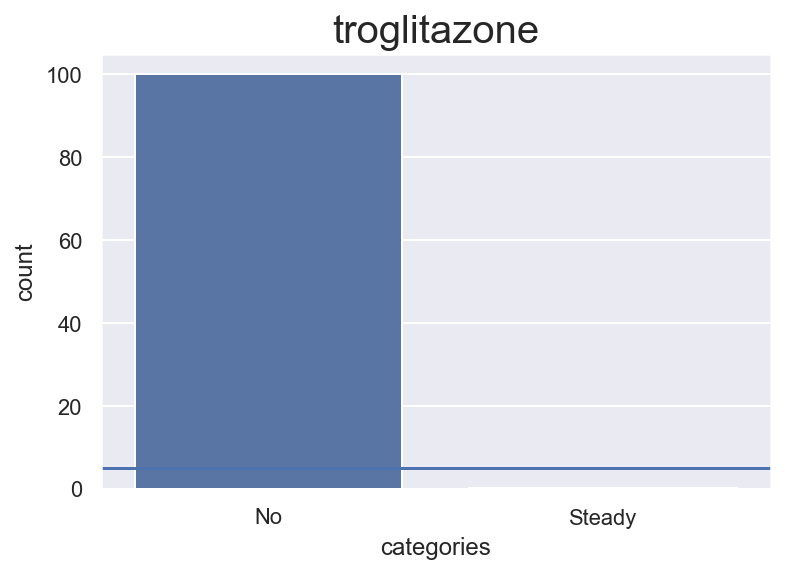

In [417]:
count_categorical_features(features_list[37]) 

tolazamide

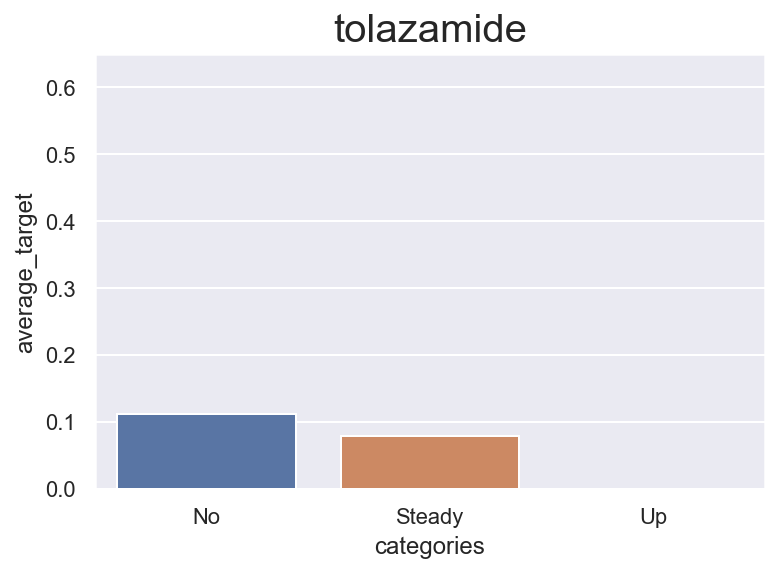

In [328]:
barplot_categorical_features(features_list[38]) 

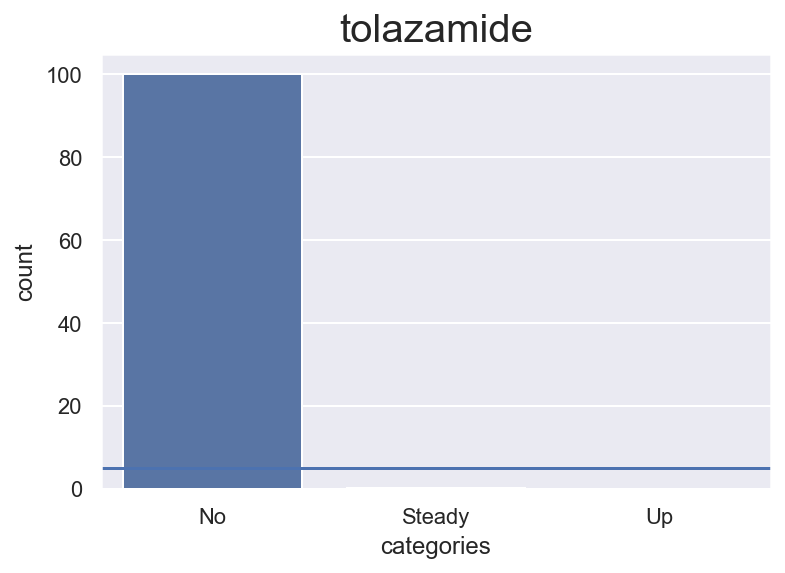

In [418]:
count_categorical_features(features_list[38]) 

examide

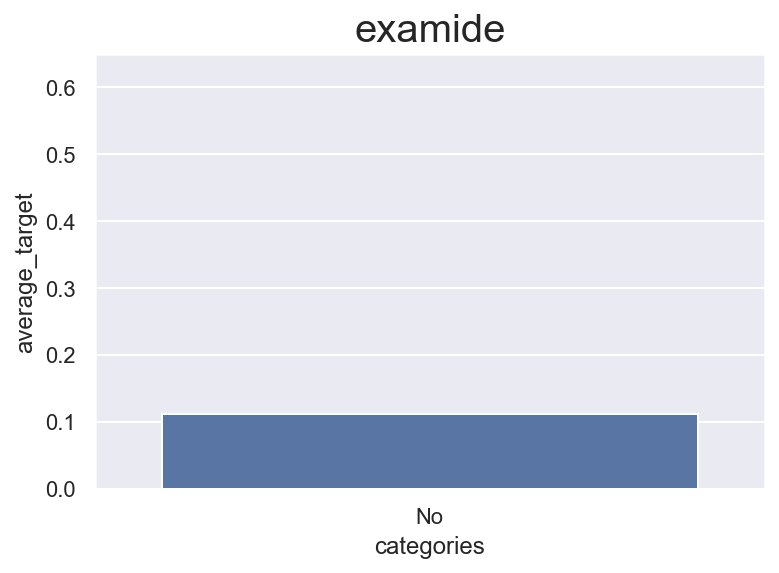

In [329]:
barplot_categorical_features(features_list[39]) 

citoglipton

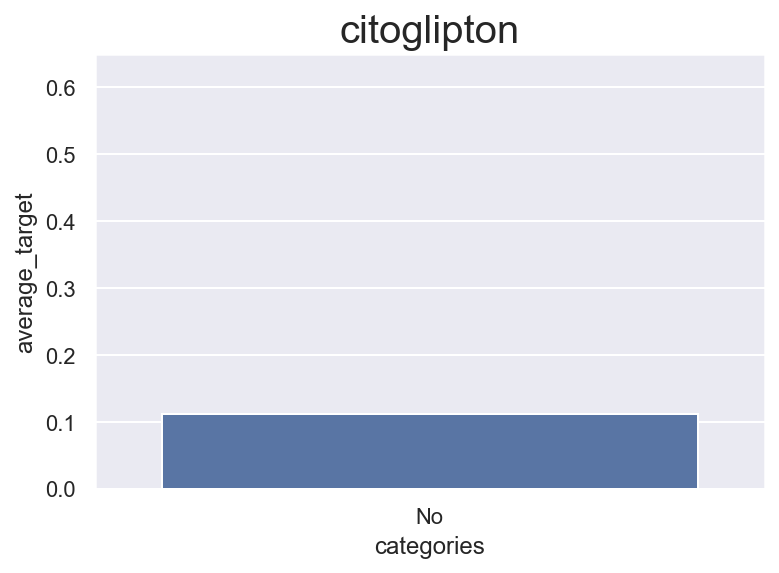

In [330]:
barplot_categorical_features(features_list[40]) 

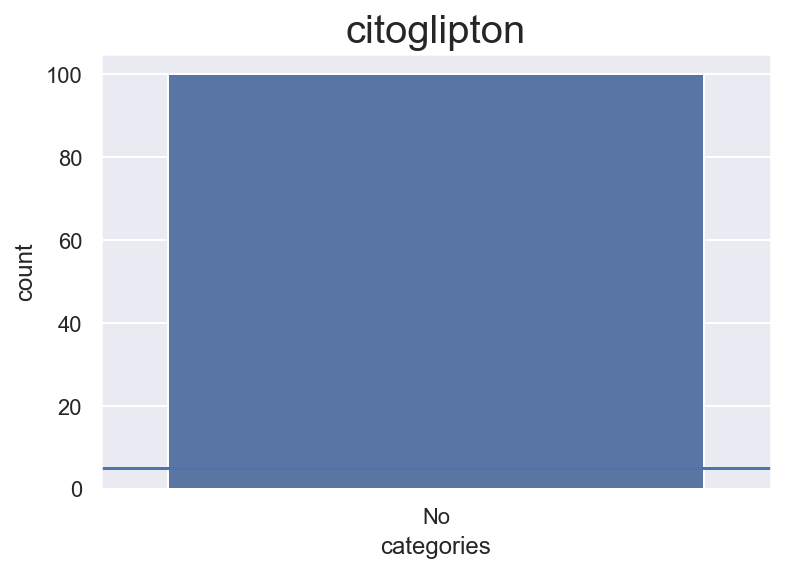

In [419]:
count_categorical_features(features_list[40]) 

Insulin

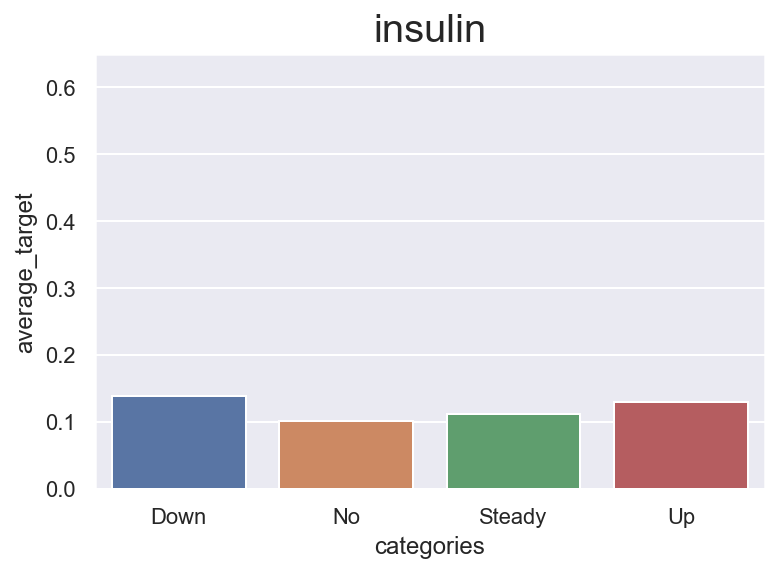

In [331]:
barplot_categorical_features(features_list[41]) 

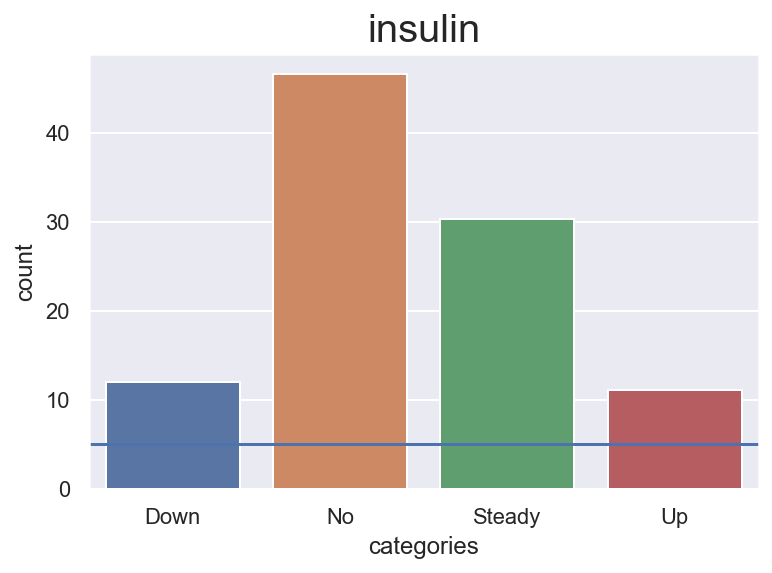

In [420]:
count_categorical_features(features_list[41]) 

glyburide-metformin

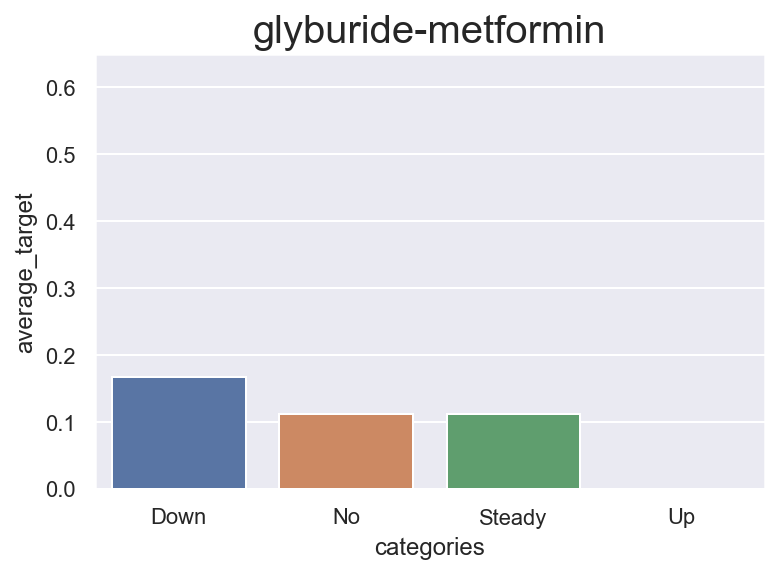

In [332]:
barplot_categorical_features(features_list[42]) 

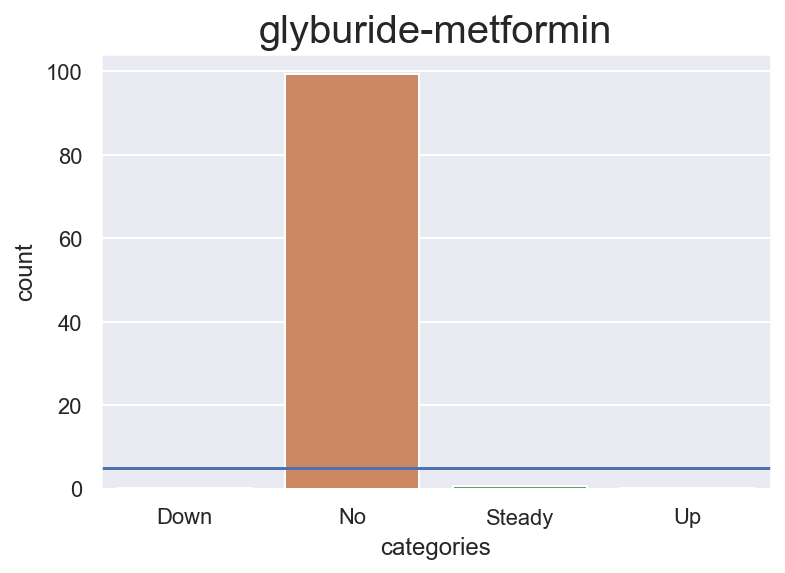

In [421]:
count_categorical_features(features_list[42]) 

glipizide-metformin

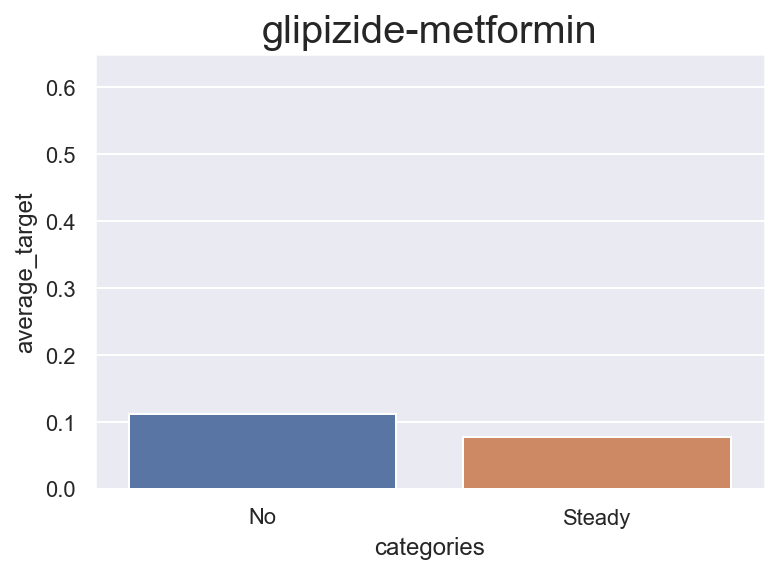

In [333]:
barplot_categorical_features(features_list[43]) 

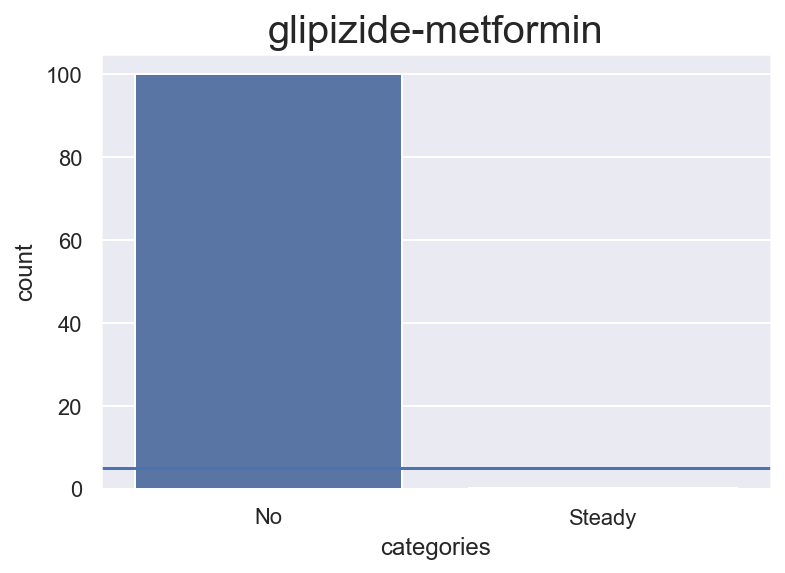

In [422]:
count_categorical_features(features_list[43]) 

glimperide-pioglitazone

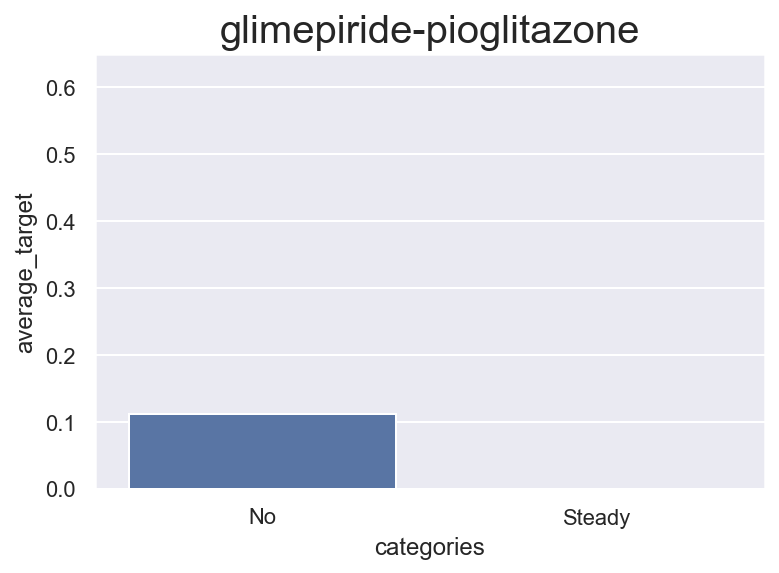

In [334]:
barplot_categorical_features(features_list[44]) 

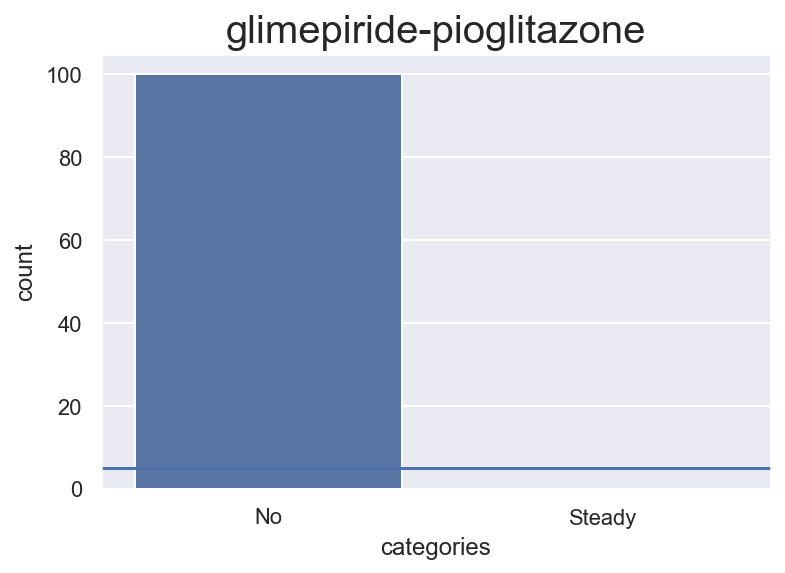

In [423]:
count_categorical_features(features_list[44]) 

metformin-rosiglitazone

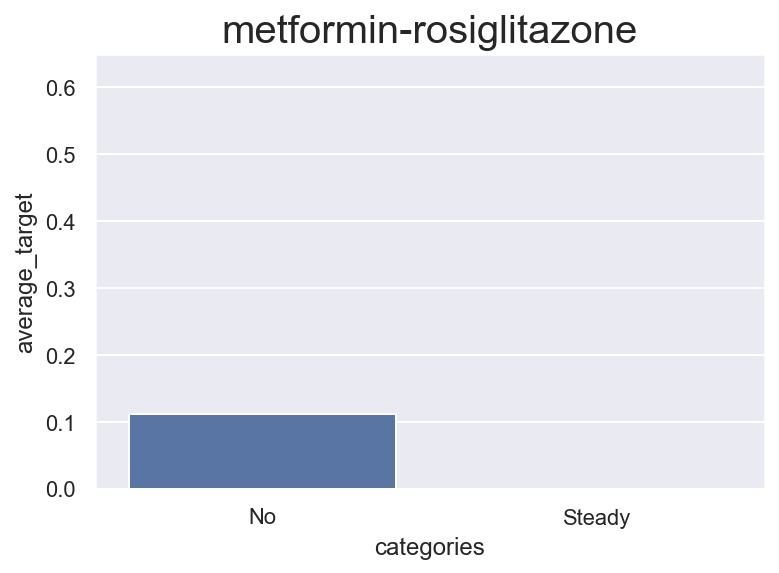

In [335]:
barplot_categorical_features(features_list[45]) 

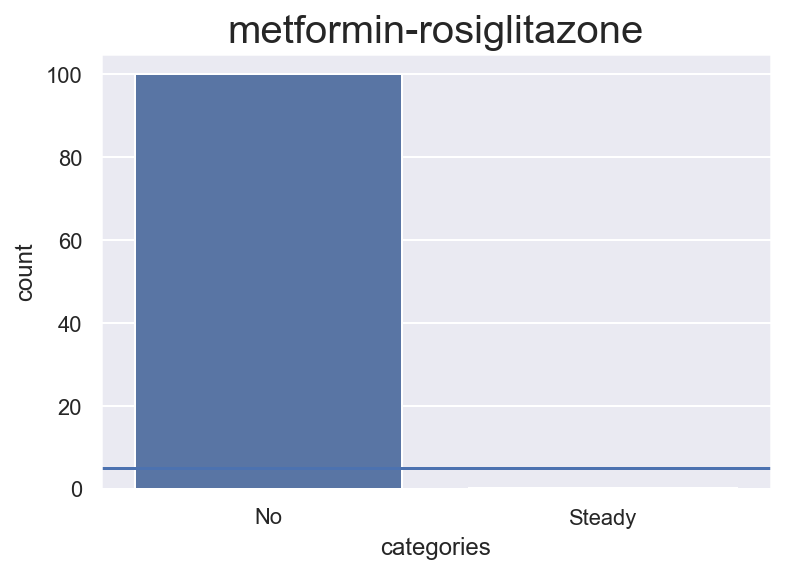

In [424]:
count_categorical_features(features_list[45]) 

metformin-pioglitazone

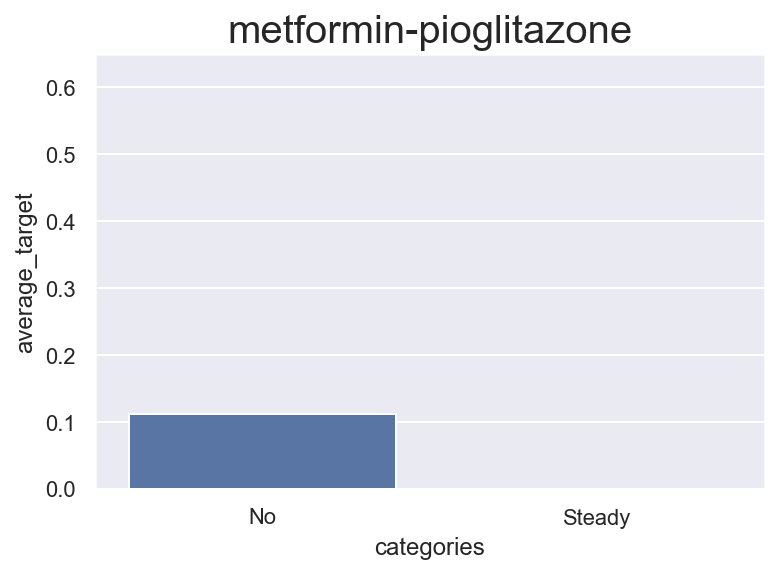

In [336]:
barplot_categorical_features(features_list[46]) 

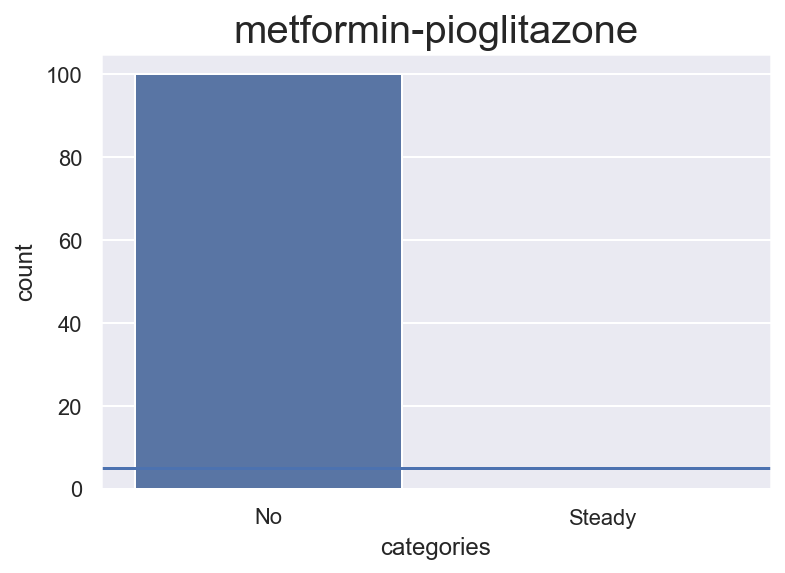

In [425]:
count_categorical_features(features_list[46]) 

Change

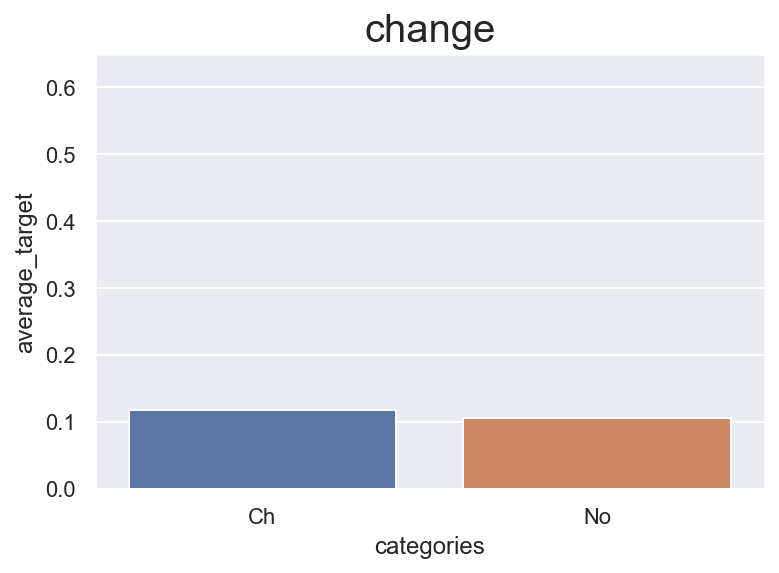

In [337]:
barplot_categorical_features(features_list[47]) 

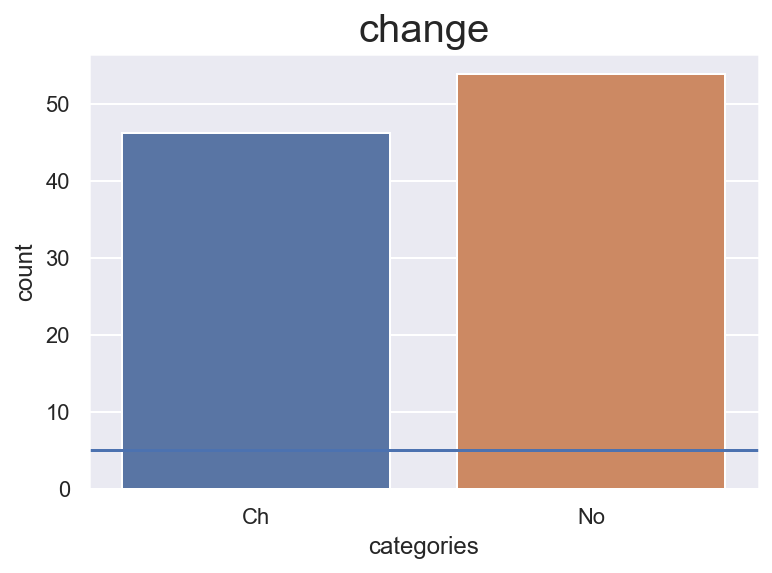

In [426]:
count_categorical_features(features_list[47]) 

DiabetesMed

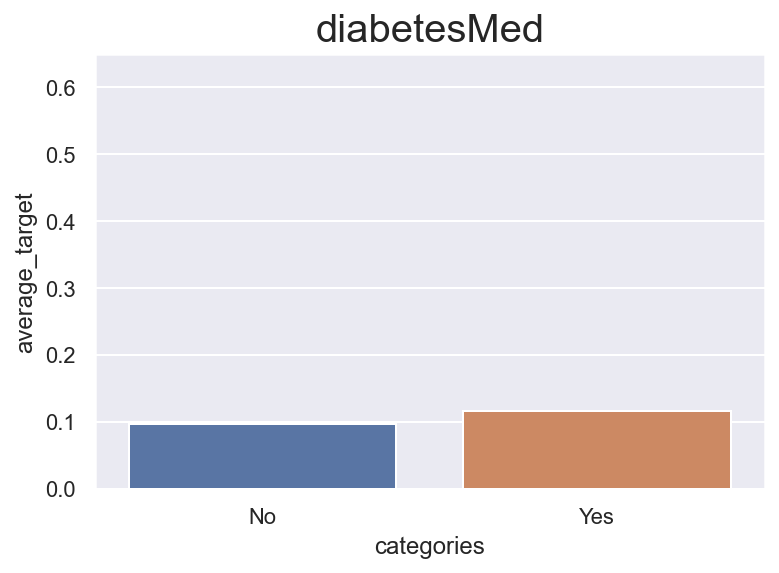

In [338]:
barplot_categorical_features(features_list[48]) 

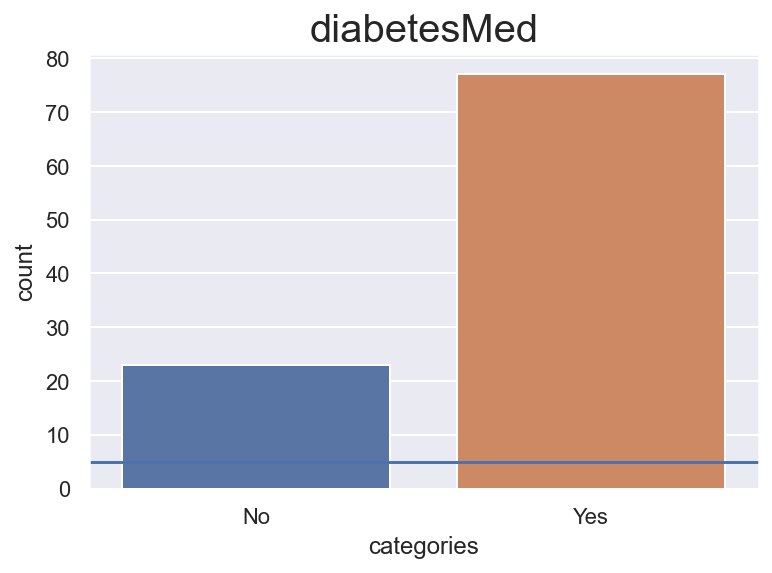

In [427]:
count_categorical_features(features_list[48]) 

In [536]:
features_model_3 = ['patient_nbr','age','readmitted_binary_target']

df_model_3 = diabetic_data[features_model_3].copy()

df_model_3.columns = features_model_3
df_model_3.head()

patient_nbr      age  readmitted_binary_target
0      8222157   [0-10)                         0
1     55629189  [10-20)                         0
2     86047875  [20-30)                         0
3     82442376  [30-40)                         0
4     42519267  [40-50)                         0

Explore new values:

Train/test split (80/20)

For the baseline, split again the train data into train and test.

In [442]:
X_train, X_val, y_train, y_val = get_patient_split_data(diabetic_data,test_size=.25)

In [444]:
X_train[['num_procedures', 'number_diagnoses']]

num_procedures  number_diagnoses
0                    0                 1
1                    0                 9
2                    5                 6
3                    1                 7
5                    6                 9
...                ...               ...
101760               1                 9
101761               0                 9
101762               3                 9
101763               0                13
101765               3                 9

[76384 rows x 2 columns]

96672

In [ ]:
from sklearn.model_selection import PredefinedSplit

In [ ]:
def split_given_size(a, size):
    return np.split(a, np.arange(size,len(a),size))

In [759]:

def train_10CV_no_bleeding(diabetic_data,X_tr,X_te,random_seed = 42):
    
    # Extract unique patients:
    total_unique_patients = X_tr['patient_nbr'].unique() 
    # Set a random seed and shuffle the unique patients:
    np.random.seed(random_seed) 
    np.random.shuffle(total_unique_patients) 

    # Find the length of each of the ten splits:
    len_split = round(np.floor(len(total_unique_patients)/10)) # = 5720
    # Generate the splits (outputs a numpy array):
    splits = split_given_size(total_unique_patients,len_split)
    # Concatenates the remainder observations into the last split (into the index 9th, it's the 10th), and then delete the splits[10]
    splits[9] = np.concatenate([splits[9], splits[10]])
    del splits[10]

    # Create a list, with the split number for each observation in X_tr['patient_nbr']
    test_fold =[]
    for i,encounter in enumerate(X_tr['patient_nbr']): # Iterates through all observation, on the patient ID column (some patients will appear more than once).
        for numFold in range(len(splits)): # for each split (there are ten) store its index.
            if encounter in splits[numFold]: # if the patient ID appears in the current fold, then append the current fold number.
                test_fold.append(numFold)
    
    test_fold = np.array(test_fold)
    ps = PredefinedSplit(test_fold) 
    print(f'{ps.get_n_splits()} splits have been successfully generated')

    return ps





In [793]:
X_tr, X_test, y_train, y_test = get_patient_split_data(diabetic_data)
ps = train_10CV_no_bleeding(diabetic_data,X_tr,X_te,random_seed = 42)

10 splits have been successfully generated


In [769]:
X_prueba = X_tr[['num_procedures', 'number_diagnoses']]

# features_model_2 = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']
X_prueba = np.array(X_prueba)
y_tr = np.array(y_tr)

In [785]:
features_model_2 = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

# features_model_2 = ['time_in_hospital']


X_prueba = X_tr[features_model_2]
X_prueba = np.array(X_prueba)
y_tr = np.array(y_tr)


In [786]:
for train_ind, val_ind in ps.split(X_prueba,y_tr):
    print(8000 in train_ind,  8000 in val_ind)
    
    X_train_fold, y_train_fold = X_prueba[train_ind], y_tr[train_ind]

    X_val, y_val = X_prueba[val_ind], y_tr[val_ind] 
    
    forest_balanced2 = RandomForestClassifier(n_estimators = 100, random_state = 0,class_weight='balanced')
    forest_balanced2.fit(X_train_fold, y_train_fold)
    print(f1_score(y_train_fold, forest_balanced2.predict(X_train_fold)),roc_auc_score(y_train_fold, forest_balanced2.predict_proba(X_train_fold)[:,1])) # Because we are working with imbalanced data.
    print(f1_score(y_val, forest_balanced2.predict(X_val)),roc_auc_score(y_val, forest_balanced2.predict_proba(X_val)[:,1])) # Because we are working with imbalanced data.

    
    # lr = LogisticRegression(solver='lbfgs')
    # lr.fit(X_train_fold, y_train_fold)
    # print(lr.score(X_val, y_val)) # Because we are working with imbalanced data.

    
    
    # print(f1_score(lr.predict(X_val), y_val)) # Because we are working with imbalanced data.
    
    
  

False True
0.9427962440232733 0.9976811060055911
0.04409171075837742 0.5757793232451404
True False
0.9415150817407323 0.997665267073534
0.05067873303167421 0.5746514490592525
True False
0.9423388028657268 0.9977074017272248
0.04035087719298246 0.5787797959550852
True False
0.9427702198496067 0.9976660821551069
0.038387715930902115 0.5629116410741929
True False
0.943505777158451 0.9976982454160221
0.04729729729729729 0.5764580247843296
True False
0.942840713053479 0.9977396848077338
0.05077062556663645 0.5783948560354535
True False
0.9421052631578948 0.9977474558781184
0.037209302325581395 0.5658138413356912
True False
0.9427877947295423 0.9976742287715054
0.042590949423247565 0.5643432217525186
True False
0.941358024691358 0.9975672798587071
0.03515263644773358 0.5662936743048593
True False
0.9413992997761579 0.9976864669656631
0.030797101449275364 0.5858181368740197


In [787]:
# features_model_2 = ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient','number_diagnoses']

features_model_2 = ['time_in_hospital']


X_prueba = X_tr[features_model_2]
X_prueba = np.array(X_prueba)
y_tr = np.array(y_tr)

In [790]:
for train_ind, val_ind in ps.split(X_prueba,y_tr):
    print(8000 in train_ind,  8000 in val_ind)
    
    X_train_fold, y_train_fold = X_prueba[train_ind], y_tr[train_ind]

    X_val, y_val = X_prueba[val_ind], y_tr[val_ind] 
    
    forest_balanced2 = RandomForestClassifier(n_estimators = 100, random_state = 0,class_weight='balanced')
    forest_balanced2.fit(X_train_fold, y_train_fold)
    print(f1_score(y_train_fold, forest_balanced2.predict(X_train_fold)),roc_auc_score(y_train_fold, forest_balanced2.predict_proba(X_train_fold)[:,1])) # Because we are working with imbalanced data.
    print(f1_score(y_val, forest_balanced2.predict(X_val)),roc_auc_score(y_val, forest_balanced2.predict_proba(X_val)[:,1])) # Because we are working with imbalanced data.

    
    # lr = LogisticRegression(solver='lbfgs')
    # lr.fit(X_train_fold, y_train_fold)
    # print(lr.score(X_val, y_val)) # Because we are working with imbalanced data.

    
    
    # print(f1_score(lr.predict(X_val), y_val)) # Because we are working with imbalanced data.
    
    
  

False True
0.20869603936148898 0.5504562471491318
0.2138084632516704 0.5585945058977361
True False
0.2095378301213419 0.5513140691230154
0.20621019108280256 0.5508116935614268
True False
0.2094165996605021 0.5517467544024766
0.20731707317073172 0.5457661574001458
True False
0.20928423812804162 0.5515798989326732
0.20844490216271883 0.5483767157352475
True False
0.2084743104259562 0.551837785992616
0.21541993495312797 0.5450991958899182
True False
0.20858077000066721 0.5505045766035291
0.21491317671092955 0.5575139545559116
True False
0.21039967918727442 0.5527911373130479
0.1983903420523139 0.5360446141438131
True False
0.20915819511325132 0.5521098332104596
0.20959999999999998 0.5406234578772457
True False
0.21021501789962865 0.5517372988809257
0.19987712471841082 0.5437269480645448
True False
0.2082581277714642 0.550276509146149
0.2177144004820245 0.5577059746069596


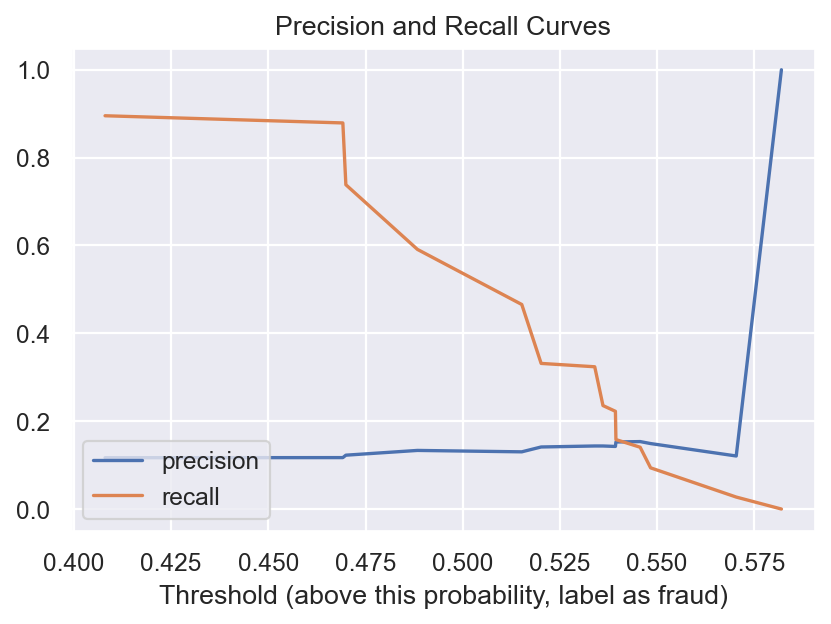

In [791]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, forest_balanced2.predict_proba(X_val)[:,1])

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

In [657]:

def get_patient_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_patients = df['patient_nbr'].unique() 
    test_patients = rs.choice(total_patients, 
                           size=int(total_patients.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['patient_nbr'].isin(test_patients)]
    df_te = df[df['patient_nbr'].isin(test_patients)] 

    y_tr, y_te = df_tr['readmitted_binary_target'], df_te['readmitted_binary_target']
    
    X_tr = df_tr.drop(['encounter_id','weight','readmitted'],axis=1) 
    X_te = df_te.drop(['encounter_id','weight','readmitted'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [95]:
len(y_train)

81478

In [97]:
len(X_train)

81478

Cross-validation: we will split keeping different patients on the training and validation folds

In [658]:
from sklearn.model_selection import PredefinedSplit

In [731]:
X_tr, X_te, y_tr, y_te = get_patient_split_data(diabetic_data)

In [667]:
total_unique_patients = X_tr['patient_nbr'].unique() 
np.random.seed(42) 
np.random.shuffle(total_unique_patients) 
total_unique_patients[10]


11240883

In [668]:
total_unique_patients[10]

11240883

Calculate split positions:

In [678]:
def split_given_size(a, size):
    return np.split(a, np.arange(size,len(a),size))

In [679]:
len_split = round(np.floor(len(total_unique_patients)/10)) # = 5720
splits = split_given_size(total_unique_patients,len_split)

In [680]:
splits[9][0]

1459548

In [681]:
splits[9] = np.concatenate([splits[9], splits[10]])
del splits[10]

In [682]:
len(splits)

10

In [683]:
8222157 in splits[0]

False

In [686]:
test_fold =[]
for i,encounter in enumerate(X_tr['patient_nbr']):
    for numFold in range(len(splits)):
        if encounter in splits[numFold]: 
            test_fold.append(numFold)

            

In [687]:
test_fold = np.array(test_fold)
ps = PredefinedSplit(test_fold)
ps.get_n_splits()


10

In [688]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression




In [798]:
X_prueba = X_tr[['num_procedures', 'number_diagnoses']]
X_prueba = np.array(X_prueba)
y_tr = np.array(y_tr)




In [732]:
len(y_tr)

81478

In [799]:
for train_ind, val_ind in ps.split(X_prueba,y_tr):
    print(8000 in train_ind,  8000 in val_ind)
    
    X_train_fold, y_train_fold = X_prueba[train_ind], y_tr[train_ind]

    X_val, y_val = X_prueba[val_ind], y_tr[val_ind] 
    
    forest_balanced2 = RandomForestClassifier(n_estimators = 100, random_state = 0,class_weight='balanced')
    forest_balanced2.fit(X_train_fold, y_train_fold)
    # (f1_score(y_val, forest.predict(X_val)), roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1]))

    print(f1_score(y_val, forest_balanced2.predict(X_val)),roc_auc_score(y_val, forest_balanced.predict_proba(X_val)[:,1])) # Because we are working with imbalanced data.

    
    # lr = LogisticRegression(solver='lbfgs')
    # lr.fit(X_train_fold, y_train_fold)
    # print(lr.score(X_val, y_val)) # Because we are working with imbalanced data.

    
    
    # print(f1_score(lr.predict(X_val), y_val)) # Because we are working with imbalanced data.
    
    
  

False True
0.20880503144654086 0.5401891339104318
True False
0.21332869323125106 0.5647208688007609
True False
0.20764462809917356 0.5524187805052452
True False
0.21097647897362792 0.5544620476344313
True False
0.21645919778699863 0.5485306791843428
True False
0.1975813953488372 0.5306656599069579
True False
0.203401969561325 0.544698873163348
True False
0.21536796536796537 0.5579544382180168
True False
0.19401155664507094 0.5375517358334241
True False
0.2135752922701099 0.5601647148727975


In [432]:
f1_score

<function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>

In [424]:
X_prueba

num_procedures  number_diagnoses
0                    0                 1
1                    0                 9
2                    5                 6
3                    1                 7
5                    6                 9
...                ...               ...
101760               1                 9
101761               0                 9
101762               3                 9
101763               0                13
101765               3                 9

[81478 rows x 2 columns]

In [407]:
grid = GridSearchCV(lm3, param_grid, cv=ps, scoring='accuracy')

NameError: name 'param_grid' is not defined

In [399]:

X_prueba = X_train[['num_procedures', 'number_diagnoses']]



type(X_prueba)

pandas.core.frame.DataFrame

In [382]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81478 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_nbr               81478 non-null  int64 
 1   race                      79681 non-null  object
 2   gender                    81478 non-null  object
 3   age                       81478 non-null  object
 4   admission_type_id         81478 non-null  int64 
 5   discharge_disposition_id  81478 non-null  int64 
 6   admission_source_id       81478 non-null  int64 
 7   time_in_hospital          81478 non-null  int64 
 8   payer_code                49264 non-null  object
 9   medical_specialty         41463 non-null  object
 10  num_lab_procedures        81478 non-null  int64 
 11  num_procedures            81478 non-null  int64 
 12  num_medications           81478 non-null  int64 
 13  number_outpatient         81478 non-null  int64 
 14  number_emergency     

In [395]:
y_train

0         0
1         0
2         0
3         0
5         0
         ..
101760    0
101761    0
101762    0
101763    0
101765    0
Name: readmitted_binary_target, Length: 81478, dtype: int64

In [396]:
X_prueba

0         0
1         0
2         5
3         1
5         6
         ..
101760    1
101761    0
101762    3
101763    0
101765    3
Name: num_procedures, Length: 81478, dtype: int64

In [401]:
lm3 = LogisticRegression()
lm3.fit(X_prueba, y_train)
lm3.score(X_prueba, y_train)

0.8872333636073542

In [360]:
test_folda = np.array([-1,0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,2,2,2,2,3,3,3,3,3,3,3,4,4,4,5,5,5,6,7,7,7,7,8,9,10])

In [84]:
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

10

Select numerical values and run a pairplot, let's see which cla

In [ ]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
f1_score(lr.predict(X_test), y_test) # Because we are working with imbalanced data.

Classification metric of choice: F1 score + choose a probability threshold (use ROC-AUC score and curve). To check for the best model.